<center>
<h3>Webinar: Series temporales: La clave para descifrar el futuro (Complemento Práctico)</h3>
</center>

En esta notebook intentaremos abordar aspectos de implementación de los conceptos presentados durante el webinar "Series temporales: La clave para descifrar el futuro". Para ello utilizaremos un dataset de llamadas de Emergencia (comúnmente conocido como 911) del condado de Montgomery en Filadelfia. El mismo puede ser descargado desde la plataforma [Kaggle](https://www.kaggle.com/mchirico/montcoalert).

En la primera parte, mostraremos aquellas funciones que permiten obtener la descomposición de las series temporales y cómo determinar la estacionariedad usando el test de Dickey-Fuller de manera de identificar patrones y comportamientos. Luego, intentaremos hacer predicciones con el algoritmo SARIMA abordando el problema de la búsqueda de hiperparámetros. Más adelante, veremos como podemos usar Holt Winters para lograr hacer una predicción que minimice alguna métrica como AIC o BIC. También se verá como son las predicciones generadas por este algoritmo en todas las combinaciones posibles de tendencia y estacionalidad. Por último, veremos como se puede implementar XGBoost para este tipo de datos.

In [0]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings

from datetime import datetime, timedelta, date
from pylab import rcParams
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from xgboost import XGBRegressor

%matplotlib inline 
plt.style.use('fivethirtyeight')

warnings.filterwarnings("ignore",category=DeprecationWarning)


In [0]:
#carga de datos
df1 = pd.read_csv('911.csv')
df1.head()

lat        lng  ...                        addr  e
0  40.297876 -75.581294  ...      REINDEER CT & DEAD END  1
1  40.258061 -75.264680  ...  BRIAR PATH & WHITEMARSH LN  1
2  40.121182 -75.351975  ...                    HAWS AVE  1
3  40.116153 -75.343513  ...          AIRY ST & SWEDE ST  1
4  40.251492 -75.603350  ...    CHERRYWOOD CT & DEAD END  1

[5 rows x 9 columns]

In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423909 entries, 0 to 423908
Data columns (total 9 columns):
lat          423909 non-null float64
lng          423909 non-null float64
desc         423909 non-null object
zip          371780 non-null float64
title        423909 non-null object
timeStamp    423909 non-null object
twp          423750 non-null object
addr         423909 non-null object
e            423909 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 29.1+ MB


Como observamos, este dataset cuenta con 9 columnas con variables categóricas, numéricas y una columna que registra los días y horarios en los cuales se recibió la llamada de emergencia (que originalmente está representado como una categoría). En esta notebook nos centraremos solo en las llamadas recibidas para trabajar con las series temporales.

In [0]:
df1['timeStamp'] = pd.to_datetime(df1['timeStamp']) #corregimos el formato de la columna timeStamp
df1['timeStamp']

0        2015-12-10 17:10:52
1        2015-12-10 17:29:21
2        2015-12-10 14:39:21
3        2015-12-10 16:47:36
4        2015-12-10 16:56:52
                 ...        
423904   2018-11-16 08:54:08
423905   2018-11-16 08:53:32
423906   2018-11-16 08:54:19
423907   2018-11-16 08:51:48
423908   2018-11-16 08:46:25
Name: timeStamp, Length: 423909, dtype: datetime64[ns]

In [0]:
print('Primera fecha cargada:', df1['timeStamp'].min(), 
      '/', 
      'Última fecha cargada:', df1['timeStamp'].max())

Primera fecha cargada: 2015-12-10 14:39:21 / Última fecha cargada: 2018-11-16 08:55:36


Al comenzar a analizar una serie temporal buscando patrones o rasgos característicos, un detalle importante a tener en cuenta es que los datos deben tomarse completos, esto significa considerar solo aquellos meses meses o semanas o cualquiera sea la frecuencia elegida cuya carga haya sido completada en su totalidad. Datos incompletos podrían generar interpretaciones erróneas y en consecuencia malas predicciones. 

Como observamos arriba, el conjunto de datos con el que estamos trabajando posee llamadas desde el 10-12-2015 hasta el 16-11-2018, a continuación tomamos la decisión de filtrar los mismos a mes cerrado (es decir, quitando el mes 12/2015 y el mes 11/2018). 

In [0]:
dt = df1['timeStamp'].max()
end = dt - timedelta(days=dt.day)
df1 = df1[df1['timeStamp']<=end]

In [0]:
df1 = df1[df1['timeStamp'].dt.year>2015]
df1.head()

lat        lng  ...                                  addr  e
7916  40.121354 -75.363829  ...        ROSEMONT AVE & W WASHINGTON ST  1
7917  40.140505 -75.310874  ...          GERMANTOWN PIKE & HANNAH AVE  1
7918  40.246837 -75.681381  ...                   VINE ST & CENTER ST  1
7919  40.097222 -75.376195  ...                    MARK LN & DEAD END  1
7920  40.148432 -75.219812  ...  BANNOCKBURN AVE & S SPRING GARDEN ST  1

[5 rows x 9 columns]

In [0]:
print('Primera fecha cargada:', df1['timeStamp'].min(), 
      '/', 
      'Última fecha cargada:', df1['timeStamp'].max())

Primera fecha cargada: 2016-01-01 00:10:08 / Última fecha cargada: 2018-10-31 08:52:06


### Introducción a Series Temporales

En esta sección mostraremos algunas funciones útiles que sirven como primer paso para estudiar y realizar un análisis previo de las series temporales. Para ello creamos un nuevo dataset con la información que nos interesa en este caso.

In [0]:
df_new = df1['title'].groupby(by=df1['timeStamp'].dt.date).count().reset_index() #contamos la cantidad de llamadas realizadas por día
df_new.columns= ['timeStamp', 'Cantidad de llamadas']
df_new.head()

timeStamp  Cantidad de llamadas
0  2016-01-01                   262
1  2016-01-02                   334
2  2016-01-03                   322
3  2016-01-04                   401
4  2016-01-05                   445

Observar que la operación anterior elimina el formato datetime de la columna timeStamp.

In [0]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 2 columns):
timeStamp               1035 non-null object
Cantidad de llamadas    1035 non-null int64
dtypes: int64(1), object(1)
memory usage: 16.3+ KB


In [0]:
df_new['timeStamp'] = pd.to_datetime(df_new['timeStamp'])

Dado un problema determinado, es importante identificar cual es la serie que mejor representa los datos y al mismo tiempo se acomoda al objetivo planteado. A continuación mostraremos diferentes maneras de obtener una serie temporal a partir del dataset. 

#### Serie diaria

El dataset de llamadas de emergencias tiene registros de cada llamada recibida distinguida por día y por hora. Una de las opciones que podría elegirse es tomar la serie que contabiliza las llamadas día por día (dejando de lado en esta oportunidad la información de la hora). Esto lo podemos hacer de la siguiente manera:

In [0]:
serie_diaria = df_new.groupby('timeStamp')['Cantidad de llamadas'].sum().reset_index().set_index('timeStamp')
serie_diaria.head()

Cantidad de llamadas
timeStamp                       
2016-01-01                   262
2016-01-02                   334
2016-01-03                   322
2016-01-04                   401
2016-01-05                   445

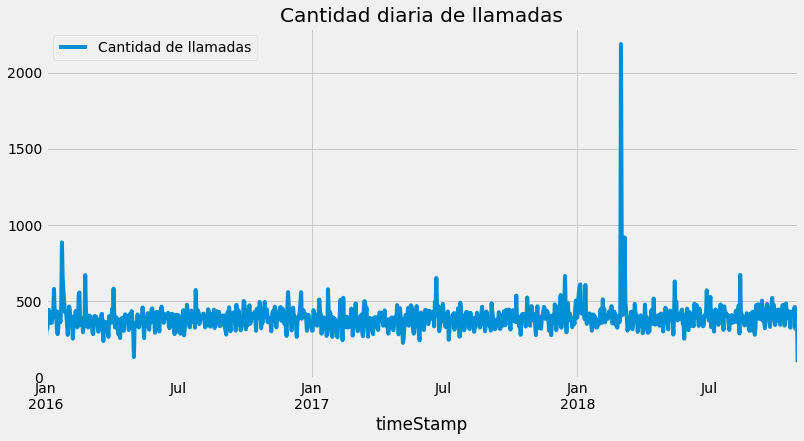

In [0]:
#Plotting data
serie_diaria.plot(figsize=(12,6), title= 'Cantidad diaria de llamadas', fontsize=14)
plt.show()

Del gráfico anterior, se puede observar que la serie temporal parece tener variaciones constantes a través del tiempo (salvo el pico que se observa entre 01/2018 y 07/2018) y sin una tendencia marcada, para este caso resulta más adecuada una descomposición aditiva.

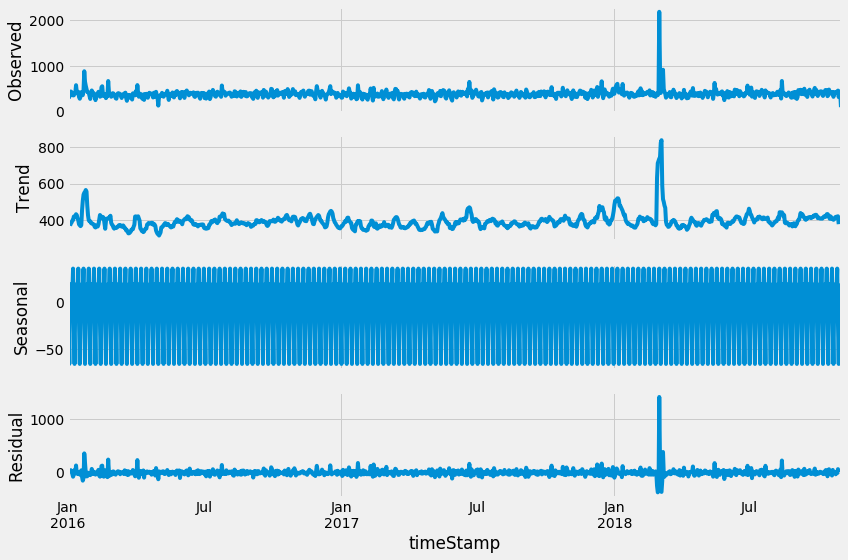

In [0]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(serie_diaria, model='additive')
fig = decomposition.plot()
plt.show()

Como se mostró durante el webinar, en una descomposicióna aditiva la serie temporal se descompone como la suma de su componente de tendencia, su componente estacional y su componente aleatoria. En este caso particular, la descomposición anterior confirma que la serie no tiene una componente de tendencia marcada pero si una componente períodica (estacional).

En algunos casos, una serie temporal con valores diarios puede tener consigo mucho ruido incorporado. Una solución a este problema es aumentar la granularidad discriminando por semanas, quincenas, meses, etc. Para estas situaciones, la función [resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) perteneciente a la librería Pandas resulta en una herramienta bastante útil. A modo de ejemplo, obtendremos la serie semanal y mensual de nuestro conjunto de datos pero se pueden utilizar otras frecuencias de manera muy similar. 

#### Serie semanal

En este caso, eligiendo el parámetro *W* y el método *sum*, estamos sumando las llamadas recibidas de cada semana considerando que la semana comienza el día domingo (esto último también puede personalizarse).

In [0]:
serie_semanal = serie_diaria['Cantidad de llamadas'].resample('W').sum()
serie_semanal.head(5)

timeStamp
2016-01-03     918
2016-01-10    2781
2016-01-17    2873
2016-01-24    3539
2016-01-31    2985
Freq: W-SUN, Name: Cantidad de llamadas, dtype: int64

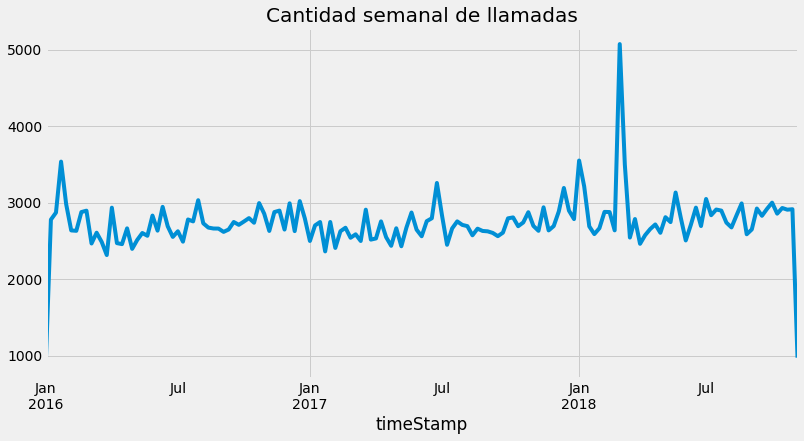

In [0]:
#Plotting data
serie_semanal.plot(figsize=(12,6), title= 'Cantidad semanal de llamadas', fontsize=14)
plt.show()

En este caso también se observa que lo más adecuado sería una descomposición aditiva.

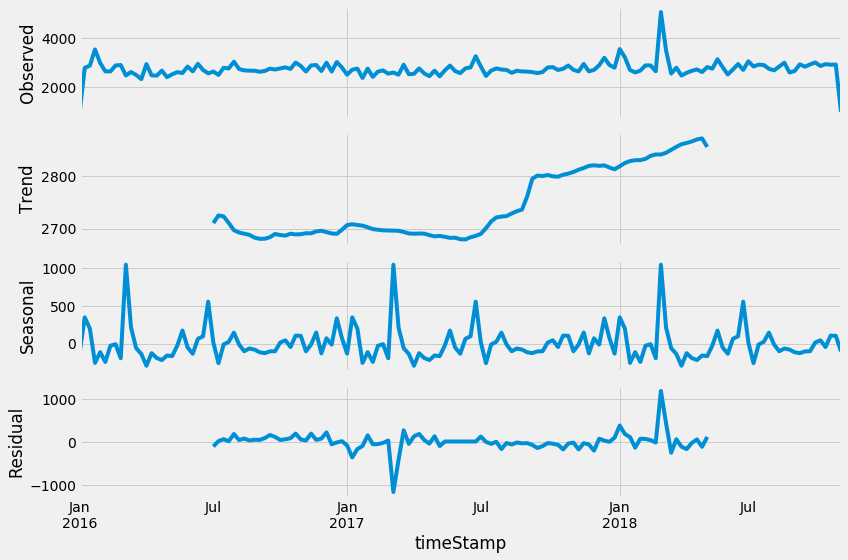

In [0]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(serie_semanal, model='additive')
fig = decomposition.plot()
plt.show()

Si bien en este caso se observa una leve tendencia, no es nada marcado y puede deberse al hecho de que contamos con menos puntos. Observar además que la misma varía en un rango de amplitud 100 el cual no es grande en comparación a los valores que toma la serie. Por otra parte, se mantiene la presencia de períodos estacionales que se repiten durante los tres años considerados.

#### Serie mensual

En este caso, con el parámetro *MS* indicamos que el resample debe realizarse por mes, comenzando el primer día.

In [0]:
serie_mensual= serie_diaria['Cantidad de llamadas'].resample('MS').sum()
serie_mensual.head(5)

timeStamp
2016-01-01    13096
2016-02-01    11396
2016-03-01    11059
2016-04-01    11287
2016-05-01    11374
Freq: MS, Name: Cantidad de llamadas, dtype: int64

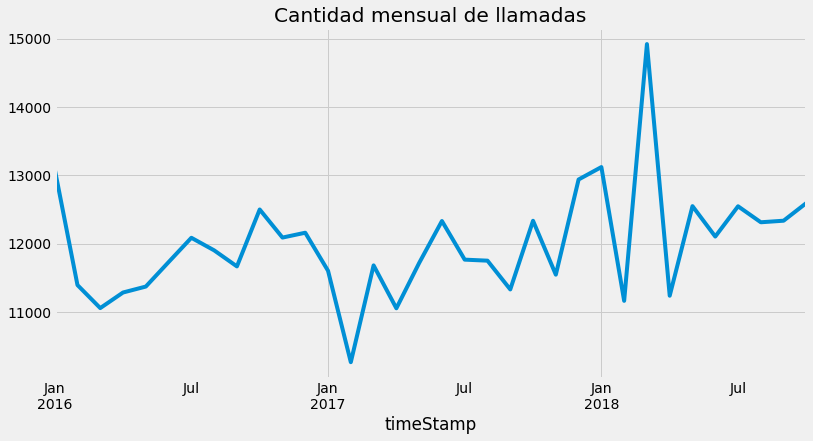

In [0]:
#Plotting data
serie_mensual.plot(figsize=(12,6), title= 'Cantidad mensual de llamadas', fontsize=14)
plt.show()

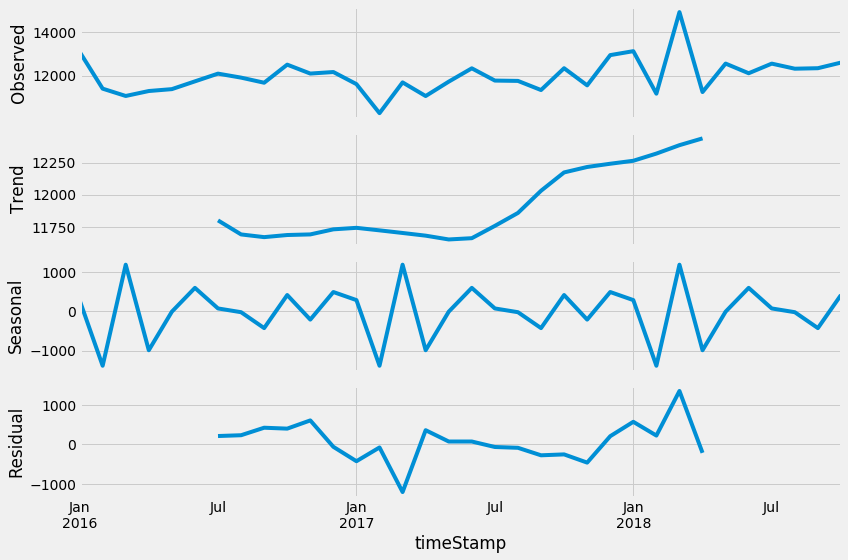

In [0]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(serie_mensual, model='additive')
fig = decomposition.plot()
plt.show()

### Análisis de estacionariedad

Como se mencionó durante el webinar, la estacionariedad es un concepto importante dentro de las series temporales. Si los estadísticos (media y desviación estándar) se mantienen constantes en el tiempo las proyecciones a futuro mantendrán esta característica y por lo tanto serán más confiables. El método más usado, y el cual veremos en esta notebook, para determinar si una serie es estacionaria es el test de Dickey-Fuller pero existen otras alternativas como el test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS) o el test Philips Perron (PP).

Para determinar la estacionariedad de una serie utilizaremos la siguiente función que calcula la media y la desviación estándar móvil y el test de estacionariedad de Dickey-Fuller. 

**IMPORTANTE:** Tener en cuenta que la variable ventana_de_tiempo depende de la frecuencia con que esté construida la serie.

In [0]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=ventana_de_tiempo).mean()
    rolstd = pd.Series(timeseries).rolling(window=ventana_de_tiempo).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='lower left')
    plt.xticks(rotation=90)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Tomemos a modo de ejemplo la serie semanal y mensual y veamos si las mismas son estacionarias.

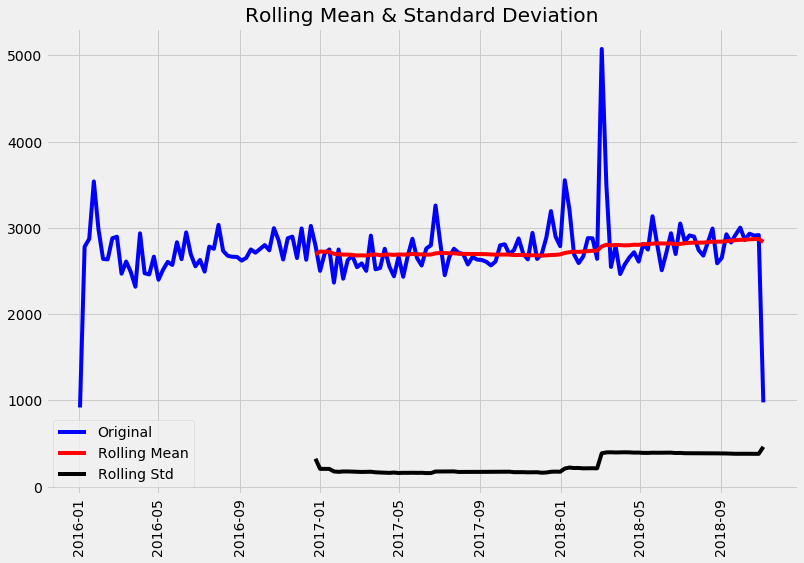

Results of Dickey-Fuller Test:
Test Statistic                -1.018444e+01
p-value                        6.564858e-18
#Lags Used                     0.000000e+00
Number of Observations Used    1.480000e+02
Critical Value (1%)           -3.475325e+00
Critical Value (5%)           -2.881275e+00
Critical Value (10%)          -2.577293e+00
dtype: float64


In [0]:
ventana_de_tiempo = 52
test_stationarity(serie_semanal)

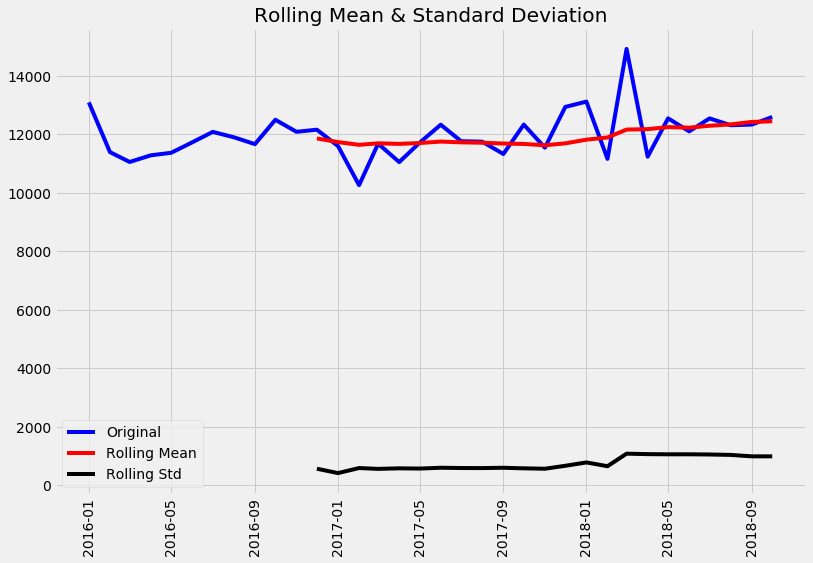

Results of Dickey-Fuller Test:
Test Statistic                 -1.844939
p-value                         0.358390
#Lags Used                      2.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [0]:
ventana_de_tiempo = 12
test_stationarity(serie_mensual)

De los cálculos anteriores y teniendo en cuenta los criterios utilizados por el test de Dickey Fuller, vemos que:
- La serie semanal es estacionaria porque p-value= 0 y el estadístico de prueba es más chico que todos los valores críticos. Por lo tanto es estacionaria con un 1% de significancia.  
- La serie mensual también es estacionaria pero con un 10% de significancia pues el valor del estadístico de prueba es más chico que el 10% de los valores críticos.

## ARIMA-SARIMA

Teniendo en cuenta la presencia de períodos estacionales en nuestra serie temporal, en este caso es mucho más adecuado utilizar el algoritmo SARIMA pues permitirá captar mejor los patrones detrás de los datos.

Recordemos que el algoritmo SARIMA posee los siguientes parámetros:

<center>
ARIMA(p,d,q)x(P,D,Q)s
</center>

donde (p,d,q) son los parámetros de la componente no estacional y (P,D,Q) están asociados a la  componente estacional. El término **s** es la periodicidad de la serie de tiempo (4 para períodos trimestrales, 12 para períodos anuales, 52 para períodos semanales, etc. )

Recordemos además que 

- **p** es la parte autoregresiva del modelo (AR) y su valor puede ser obtenido a partir del gráfico de Autocorrelación Parcial (PACF), identificando la primera vez que dicho gráfico cruza la región de confianza. Este valor permite incorporar el efecto de los valores pasados en la predicción.
- **d** es la cantidad de veces que los datos deben ser diferenciados (es decir, el número de valores pasados que se sustraen al valor actual) para obtener datos estacionarios y corresponde a la parte integrada del modelo (I). Los modelos ARIMA trabajan con datos estacionarios.
- **q** se corresponde con la parte de media móvil del modelo (MA) y su valor puede ser obtenido a partir del gráfico de Autocorrelación (ACF), identificando el valor donde dicho gráfico cruza por primera vez la región de confianza. Este término está asociado con los errores.


A continuación, intentaremos determinar los parámetros p y q a partir de los gráficos de autocorrelación y correlación parcial. Recordemos que estos gráficos pueden realizarse de dos maneras: como se muestra en la función *tsplot* definida abajo (que es la forma más convencional) o bien uniendo los puntos de los lags del gráfico anterior y trazando la curva que une los puntos. Con ambas versiones deben obtenerse los mismos resultados.

A modo de ejemplo, vamos usaremos la serie mensual.

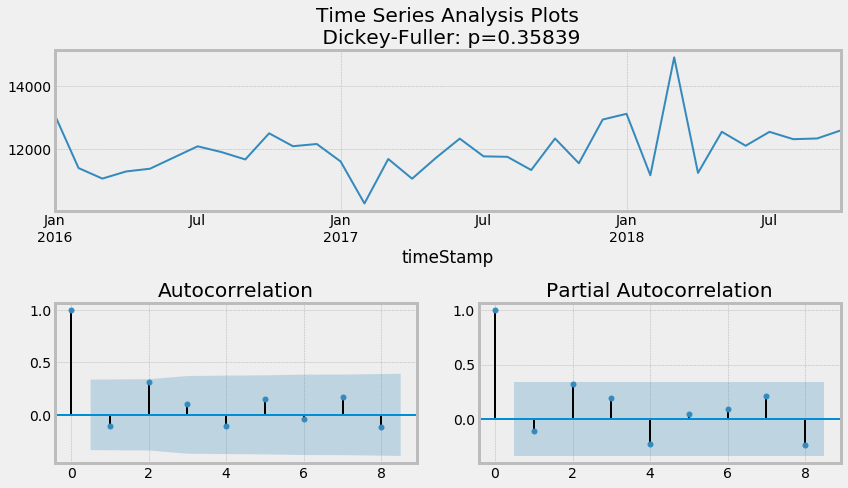

In [0]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax= acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(serie_mensual, lags=8)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


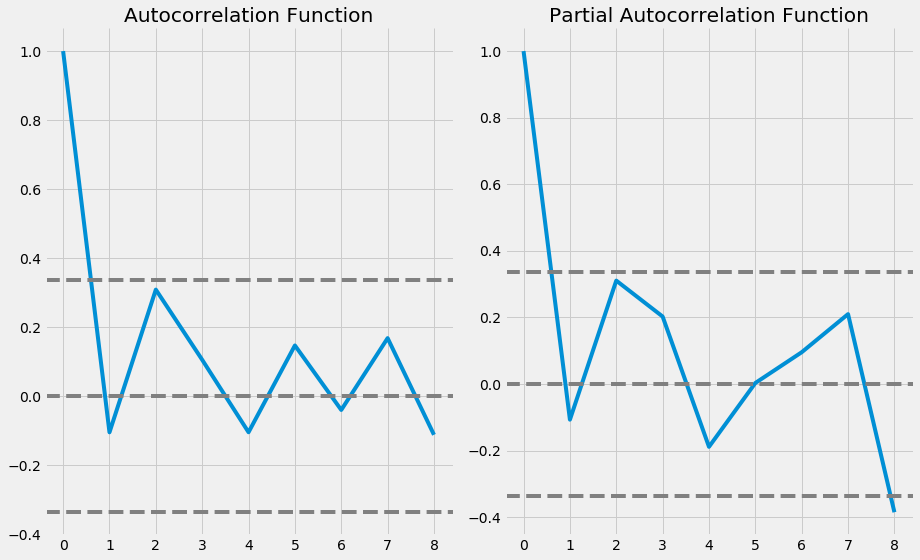

In [0]:
plt.figure(figsize=(13,8))

lag_acf = acf(serie_mensual, nlags=8)
lag_pacf = pacf(serie_mensual, nlags=8, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(serie_mensual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(serie_mensual)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
x = np.array([0,1,2,3,4,5,6,7,8])
plt.xticks(x)


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(serie_mensual)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(serie_mensual)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
x = np.array([0,1,2,3,4,5,6,7,8])
plt.xticks(x)
plt.tight_layout()
sns.despine()

De los gráficos anteriores observamos que:

- El valor de p debería ser 1 pues es el valor de retraso en el cual el gráfico de Autocorrelación Parcial (PACF) entra la región de confianza (o bien cruza la línea punteada gris en el gráfico de arriba)
- El valor de q debería ser también 1 pues es el valor de retraso en el cual el gráfico de Autocorrelación (ACF) entra la región de confianza (o bien cruza la línea punteada gris en el gráfico de arriba).


Habiendo determinado los valores de p y q restaría obtener el valor d. Si bien la serie mensual que estamos considerando es estacionaria, aplicaremos el proceso de diferenciación por dos razones:
- Para mostrar como llevar a cabo el proceso de diferenciar una serie.
-  Para obtener un mayor nivel de significancia en el rechazo de la hipótesis del test de Dickey Fuller (hasta el momento logramos un rechazo con un 10% de significancia). 

In [0]:
first_diff = serie_mensual.diff() #primera diferenciación
second_diff = serie_mensual.diff().diff() #segunda diferenciación

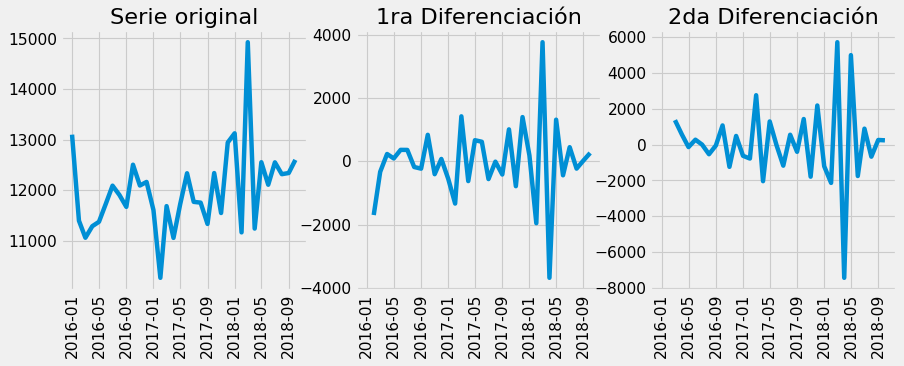

In [0]:
plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':80})

# Serie Original
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(serie_mensual) 
axes[0].set_title('Serie original')

# Primera Diferenciación
axes[1].plot(first_diff.dropna())
axes[1].set_title('1ra Diferenciación')

# Segunda Diferenciación
axes[2].plot(second_diff.dropna())
axes[2].set_title('2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.show()

Observemos todo en un mismo gráfico.

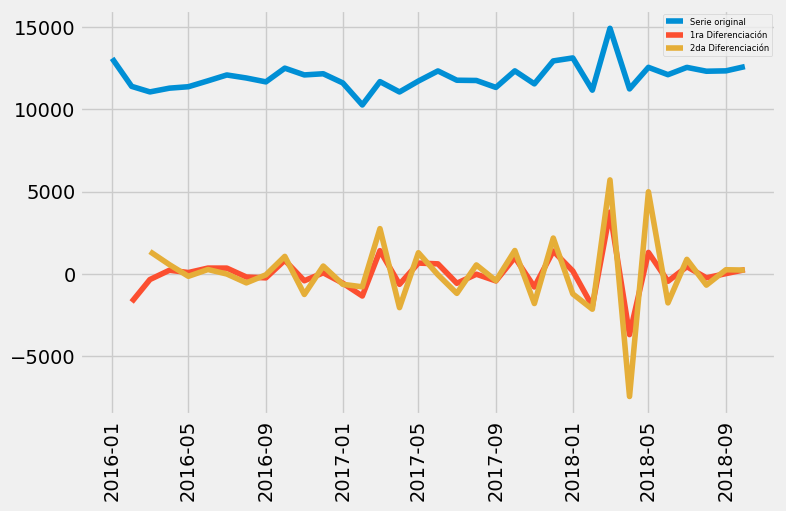

In [0]:
fig, axes = plt.subplots(1, 1, figsize=(8,5), dpi=100, sharex=True)

axes.plot(serie_mensual, label='Serie original')
axes.plot(first_diff, label='1ra Diferenciación')
axes.plot(second_diff, label='2da Diferenciación')
axes.legend(loc='upper right', fontsize=6)
plt.xticks(rotation=90)

plt.show()

La identificación del parámetro d en sí no es algo demasiado simple pero existen algunos criterios que ayudan a su elección. Uno de ellos es mirar los gráficos de Autocorrelación Parcial de cada una de las series diferenciadas y ver si los mismos tienden progresivamente a cero.

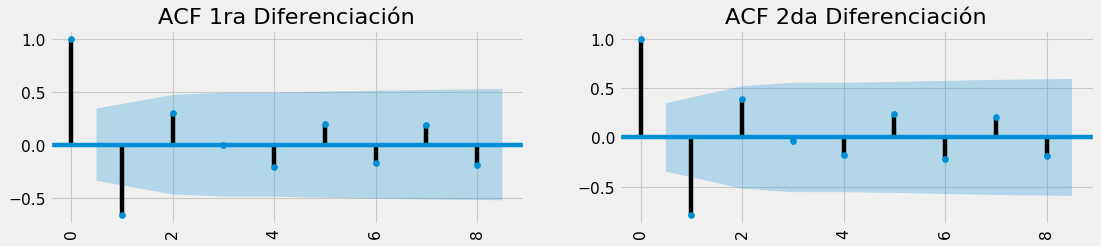

In [0]:
plt.rcParams.update({'figure.figsize':(15,3), 'figure.dpi':80})

fig, axes = plt.subplots(1, 2, sharex=True)
# 1st order Differencing
plot_acf(first_diff.dropna(),lags=8,ax=axes[0], title='ACF 1ra Diferenciación')

# 2nd order Differencing
plot_acf(second_diff.dropna(), lags=8,ax=axes[1] , title='ACF 2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace = 0.5)
plt.show()


De los gráficos anteriores observamos que con un order de diferenciación alcanzaría para obtener una serie estacionaria pues el gráfico de autocorrelación tiende progresivamente a cero. A continuación verificaremos esto usando el test de estacionariedad de Dickey Fuller.

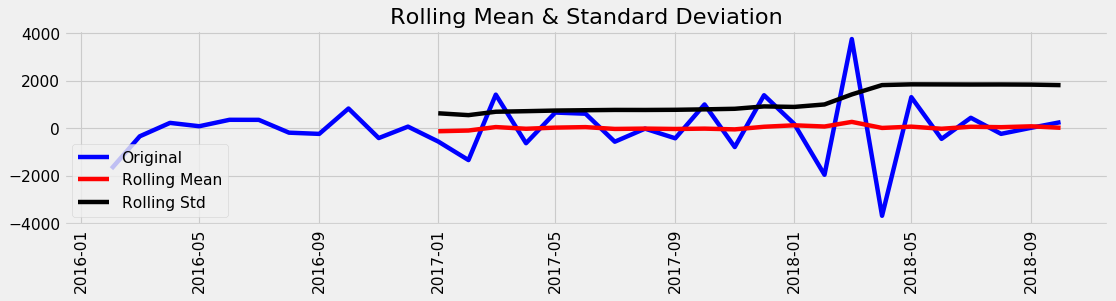

Results of Dickey-Fuller Test:
Test Statistic                -7.824249e+00
p-value                        6.545770e-12
#Lags Used                     1.000000e+00
Number of Observations Used    3.100000e+01
Critical Value (1%)           -3.661429e+00
Critical Value (5%)           -2.960525e+00
Critical Value (10%)          -2.619319e+00
dtype: float64


In [0]:
ventana_de_tiempo = 12
test_stationarity(first_diff.dropna())

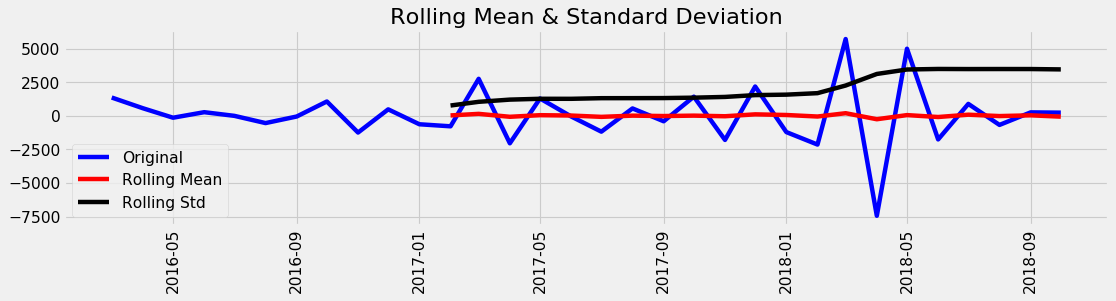

Results of Dickey-Fuller Test:
Test Statistic                 -2.963477
p-value                         0.038449
#Lags Used                     10.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [0]:
ventana_de_tiempo = 12
test_stationarity(second_diff.dropna())

Los resultados del test de estacionariedad aplicado a la serie diferenciada indican que una diferenciación sería suficiente para obtener datos estacionarios pero con dos diferenciaciones también alcanzamos el mismo resultado.

El procedimiento para obtener P y D es muy similar a lo visto anteriormente pero en lugar de tomar diferencias 'lag a lag' (o retraso a retraso), las diferencias se toman por estación o período y se utilizan ACF y PACF nuevamente.

## Búsqueda de hiperparámetros

El procedimiento anterior resulta muy ineficiente y poco práctico cuando tenemos un conjunto de datos que se actualiza constantemente y necesitamos hacer predicciones "on the road". En estos casos, lo más adecuado es realizar una búsqueda de hiperparámetros y elegir el modelo que mejor se ajuste a los datos. 

Entre las métricas más usadas para comparar diferentes modelos ARIMA se encuentran el Criterio de Información de Akaike (AIC por sus siglas en inglés) y el Criterio de Información Bayesiano (BIC por sus siglas en inglés). En este caso debido a la cantidad de paramétros que necesitamos estimar elegimos AIC. AIC es un estimador de la calidad relativa de los modelos estadísticos para un conjunto de datos y toma en cuenta la complejidad del mismo. De esta manera, un modelo que proporciona un buen ajuste pero usando muchos features recibirá un valor más grande de AIC comparado con otro que devuelve el mismo ajuste pero utilizando menos features. Así, nos interesan aquellos modelos que proporcionan el valor más bajo de AIC.

A continuación mostramos un ejemplo de como se realizaría la búsqueda de hiperparámetros y la elección del mejor modelo.

In [0]:
window = 12

En primer lugar, generamos el espacio de búsqueda de nuestros parámetros. Dado que nuestra serie presenta una estacionalidad bien marcada es usual en estos casos setear D=1, caso contrario también se procede a buscar en este parámetro.

In [0]:
p = range(0,3)
d = range(0,3)
q = range(0,3)
P = range(0,3)
D = [1]
Q = range(0,3)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], window) for x in list(itertools.product(P, D, Q))]

In [0]:
bestAIC = np.inf
bestParam = None
bestSParam = None

warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(serie_mensual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}{} - AIC:{}'.format(param, 
                                                 param_seasonal,
                                                 window,
                                                 results.aic))
            #if current run of AIC is better than the best one so far, overwrite it
            if results.aic<bestAIC:
                bestAIC = results.aic
                bestParam = param
                bestSParam = param_seasonal
                
        except Exception as e:
                print(e)
                print('except')
                continue
                
mod = sm.tsa.statespace.SARIMAX(serie_mensual,
                                    order=bestParam,
                                    seasonal_order=bestSParam,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
results = mod.fit()

ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:350.4341074038469
maxlag should be < nobs
except
maxlag should be < nobs
except
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:175.01005500876744
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:334.2710679822185
maxlag should be < nobs
except
maxlag should be < nobs
except
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:176.13155607067696
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:314.4752385804448
maxlag should be < nobs
except
maxlag should be < nobs
except
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:171.30640067818126
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
maxlag should be < nobs
except
ARIMA(0, 1, 0)x(

En los resultados anteriores se observa que existieron algunas combinaciones de parámetros que no pudieron entrenarse, esto se debe a que los valores de los parámetros y el número de observaciones disponibles están estrechamente relacionadas. Una ecuación que puede seguirse en la siguiente:

Dado un modelo SARIMA (p,d,q)x(P,D,Q,s), se necesitarán al menos 
$$
d + D*s + max(3*q + 1, 3*Q*s + 1, p, P*s) + 1 
$$

observaciones.

- Por ejemplo:

    - (0, 0, 0)x(1, 0, 0, 52) => 0 + 0 + 52 + 1 = 53
    - (0, 0, 0)x(1, 1, 0, 52) => 0 + 52 + 52 + 1 = 105
    - (0, 0, 0)x(2, 1, 0, 52) => 0 + 52 + 104 + 1 = 157
    - (0, 0, 0)x(0, 0, 1, 52) => 0 + 0 + 3*52+1 + 1 = 158
    - (0, 0, 0)x(0, 1, 1, 52) => 0 + 52 + 3*52+1 + 1 = 210
    - (0, 0, 0)x(1, 1, 1, 52) => 0 + 52 + 3*51+1 + 1 = 210

Finalmente, para ver el mejor modelo obtenido podemos llamar al atributo Summary de SARIMA.

In [0]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:               Cantidad de llamadas   No. Observations:                   34
Model:             SARIMAX(2, 2, 0)x(1, 1, 0, 12)   Log Likelihood                 -42.318
Date:                            Tue, 03 Mar 2020   AIC                             92.636
Time:                                    12:01:07   BIC                             91.803
Sample:                                01-01-2016   HQIC                            89.301
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7626      0.790     -0.966      0.334      -2.310       0.785
ar.L2         -0.2531      0.383   

En este caso, observamos que los parámetros finales fueron (2, 2, 1)x(1, 1, 0, 12) que si bien no coinciden exactamente con el análisis inicial aquí estuvimos comparando perfomance entre diferentes modelos y esta combinación es la que nos proporciona un valor más bajo de nuestra métrica (AIC).

Habiendo entrenado el mejor modelo estamos en condiciones de hacer predicciones para el siguiente período (12 meses adelante).

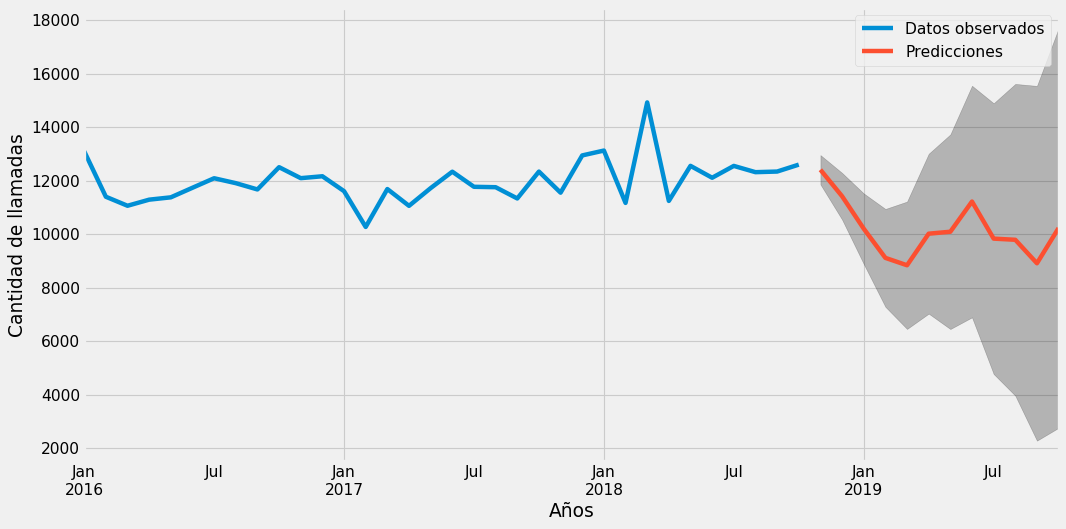

In [0]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = serie_mensual.plot(label='Datos observados', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Predicciones')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Años')
ax.set_ylabel('Cantidad de llamadas')
plt.legend()
plt.show()

Las predicciones a futuro obtenidas parecen captar el comportamiento general de nuestro datos. Las franjas grises observadas son los intervalos de confianza para los valores obtenidos. Tener en cuenta que más allá de los valores de las predicciones la idea es mostrar como se lleva a cabo un proceso de predicción usando ARIMA y la complejidad que trae consigo.

# HOLT-WINTERS

##  Un poco de historia

Еxponential smoothing aparece por primera vez en el trabajo de Siméon Poisson (1781-1840), pero su aplicacóon para hacer predicciones fue usada recién en 1956 por Robert Brown (1923–2013) en su publicación "Smoothing for Predicting Demand".

En 1957, el profesor Charles C. Holt (1921-2010) trabajaba en Carnegie Mellon University pronosticando tendencias en la producción, inventarios y mano de obra. Holt y Brown trabajaron independientemente y no sabían del trabajo del otro. Holt publicó un artículo titulado “Forecasting trends and seasonals by exponentially weighted moving averages”  que describe el suavizado exponencial doble. Tres años más tarde, en 1960, Peter R. Winters mejoró el algoritmo al agregar la estacionalidad y publicó "Forecasting sales by exponentially weighted moving averages" citando el artículo del Dr. Holt de 1957 como trabajos anteriores sobre el mismo tema. Este algoritmo se conoce como el suavizado exponencial triple o el método Holt-Winters.


## Funciones útiles

Comenzaremos creando funciones para separar los datos, calcular dos métricas distintas (AIC y BIC) y tambien para encontrar la mejor combinación de hiperparámetros de tal manera que minimice dichas métricas:

In [0]:
def sep_train_test(data,porcentaje = 0.8): # separa en train y test
    lim = round(data.shape[0]*porcentaje)
    train = data[:lim]
    test = data[lim:]
    return train,test,lim

In [0]:
def AIC(n,y_true, y_pred, num_params):      # es usado como metrica, n es el numero de muestras
    mse = mean_squared_error(y_true,y_pred)
    aic = n * math.log(mse) + 2 * num_params
    return aic

In [0]:
def BIC(n, y_true, y_pred, num_params):     # es otra metrica que puede ser util, n es el numero de muestras
    mse = mean_squared_error(y_true,y_pred)
    bic = n * math.log(mse) + num_params * math.log(n)
    return bic

In [0]:
def enc_hiperparametros(data, porcentaje=0.8, periodo=52): 
    trend = ['additive','multiplicative',None]             
    seasonal = ['additive','multiplicative',None]       
    b = [True, False]
    r = [True, False]
    d = [True, False]
    conv  = []
    train, test, limi = sep_train_test(data, porcentaje)
    n = []
    for i in trend:
        for j in seasonal:
            for m in d:
                for l in b:
                    for k in r:
                        if (i==None):
                            triple = ExponentialSmoothing(train['Cantidad de llamadas'],
                                                      trend=i,    
                                                      seasonal=j,       
                                                      seasonal_periods=periodo,
                                                      ).\
                            fit(optimized=True, use_boxcox=l, remove_bias=k)
                            
                        else:
                            triple = ExponentialSmoothing(train['Cantidad de llamadas'],
                                                      trend=i,    
                                                      seasonal=j,       
                                                      seasonal_periods=periodo,
                                                      damped=m).\
                            fit(optimized=True, use_boxcox=l, remove_bias=k)
                        
                        y_pred = triple.forecast(test.shape[0])
                        y_true = test['Cantidad de llamadas']
                        num_params = 3
                        if trend == None:
                            num_params=num_params-1
                        if seasonal == None:
                            num_params = num_params -1
                        
                        y_pred.fillna(0,inplace=True)
                        er = AIC(len(y_true),y_true,y_pred,num_params)
                        conv.append((i,j,m,l,k,er))
                        n.append(er)
    print(n.index(min(n)))
    return conv,limi, n.index(min(n))

Usamos el dataframe obtenido antes llamado 'serie_diaria'.

In [0]:
serie_diaria.head()

Cantidad de llamadas
timeStamp                       
2016-01-01                   262
2016-01-02                   334
2016-01-03                   322
2016-01-04                   401
2016-01-05                   445

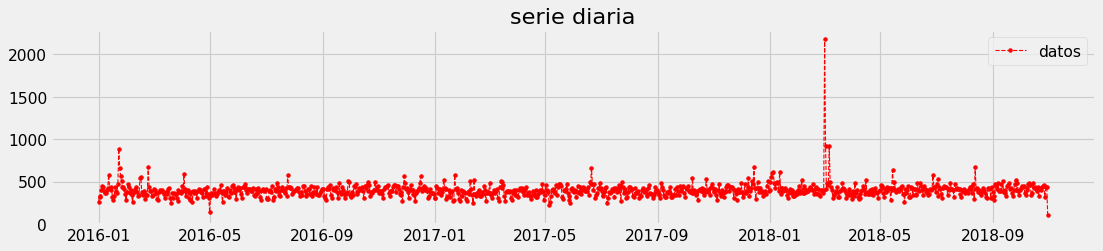

In [0]:
plt.plot(serie_diaria.index, serie_diaria['Cantidad de llamadas'], 
         marker='.', ls='--', linewidth=1,color='red', label='datos')
plt.title('serie diaria')
plt.legend()
plt.show()

Recordemos del análisis previo que esta serie tiene una tendencia aditiva y una estacionalidad aditiva también. A continuación veremos que hiperparámetros minimizan las métricas usando la funcion creada arriba.

## Llamadas diarias

In [0]:
# separo en train y test
train, test, lim = sep_train_test(serie_diaria)
train = train['Cantidad de llamadas'].values
test = test['Cantidad de llamadas'].values

In [0]:
# encuentro la mejor combinacion de parametros
conv, lim, n = enc_hiperparametros(serie_diaria, porcentaje=0.8, periodo=53) 

20


In [0]:
# con esto obtengo la mejor combinacion  de hiperparametros
print('Tendencia: ',conv[n][0])
print('Estacionalidad: ',conv[n][1])

Tendencia:  additive
Estacionalidad:  None


Si bien existeb más hiperparámetros, estos son los que realmente interesan en este momento.

Vemos que la función encontró la tendencia aditiva pero no la estacionalidad (None). Recordar que esta función encuentra los hiperparámetros usando como criterio la obtención de la menor métrica y no quiere decir que no podamos buscar otra combinación que se adapte mejor al problema que estamos tratando.


Reentrenamos con la combinación más óptima y predecimos.

In [0]:
if (conv[n][0]==None):
    triple = ExponentialSmoothing(train,
                              trend=conv[n][0],   
                              seasonal=conv[n][1],       
                              seasonal_periods=365,
                              ).\
    fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
else:
    triple = ExponentialSmoothing(train,
                              trend=conv[n][0],    
                              seasonal=conv[n][1],      
                              seasonal_periods=365,
                              damped=conv[n][2]).\
    fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
triple_preds = triple.forecast(len(test))

#### Gráfico de los resultados

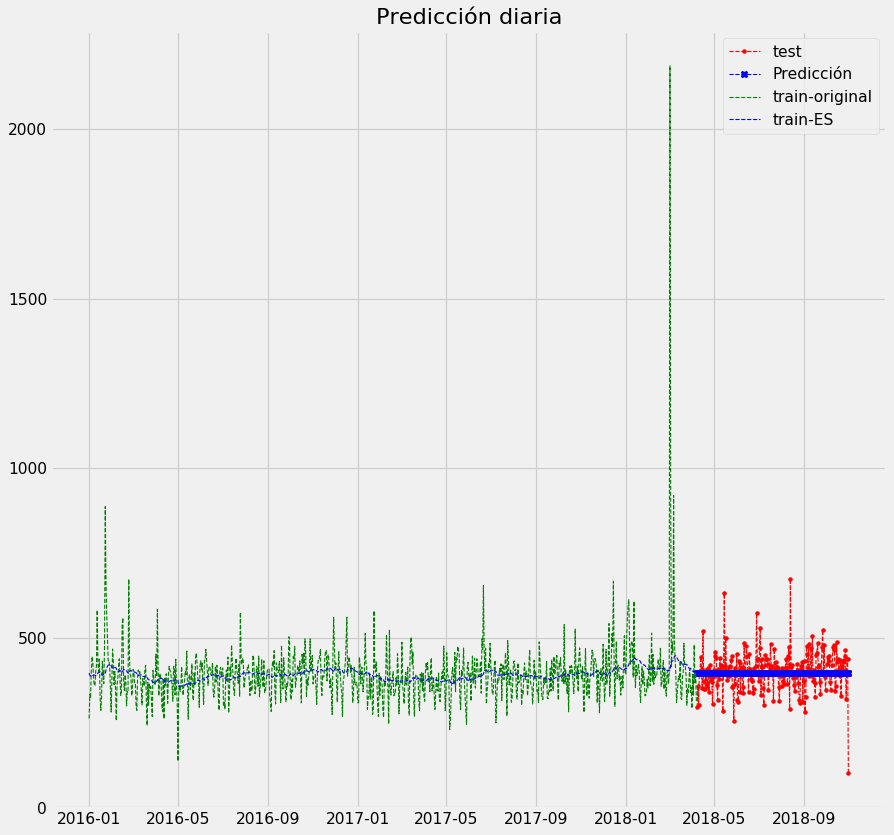

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_diaria.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_diaria.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción diaria')
plt.legend()
plt.show()

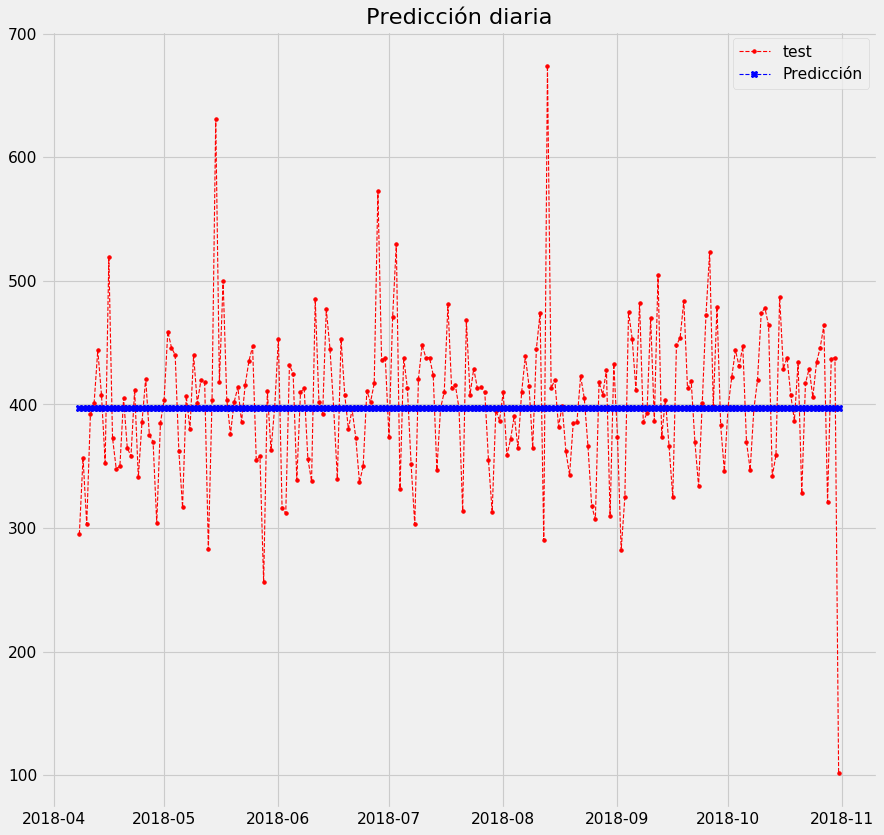

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción diaria')
plt.legend()
plt.show()

In [0]:
triple.params

{'damping_slope': nan,
 'initial_level': 1.8976312082447355,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 1.7204486439331344e-07,
 'lamda': -0.5002101879860944,
 'remove_bias': True,
 'smoothing_level': 0.03779511705869161,
 'smoothing_seasonal': nan,
 'smoothing_slope': 0.0,
 'use_boxcox': True}


En el grafico anterior podemos ver cuales son los datos con lo que entrenó el modelo y cómo los "suavizo", también se ve la predicción y el valor real obtenido. Los parámetros 𝛼 (smoothing_level), 𝛽 (smoothing_slope) y 𝛾 (smoothing_seasonal) dieron 0.044, 0.0 y nan respectivamente. En este caso podemos decir que el modelo que se usó es un exponencial smoothing doble porque no tiene estacionalidad.


A continuación exploraremos las siguientes combinaciones:

* Tendencia aditiva y estacionalidad aditiva.
* Tendencia aditiva y estacionalidad multiplicativa.
* Tendencia multiplicativa y estacionalidad aditiva.
* Tendencia multiplicativa y estacionalidad multiplicativa.


###### Tendencia aditiva y estacionalidad aditiva

In [0]:
triple = ExponentialSmoothing(train,
                          trend='add',    
                          seasonal='add',   
                          seasonal_periods=365,
                          ).\
fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
        
triple_preds = triple.forecast(len(test))

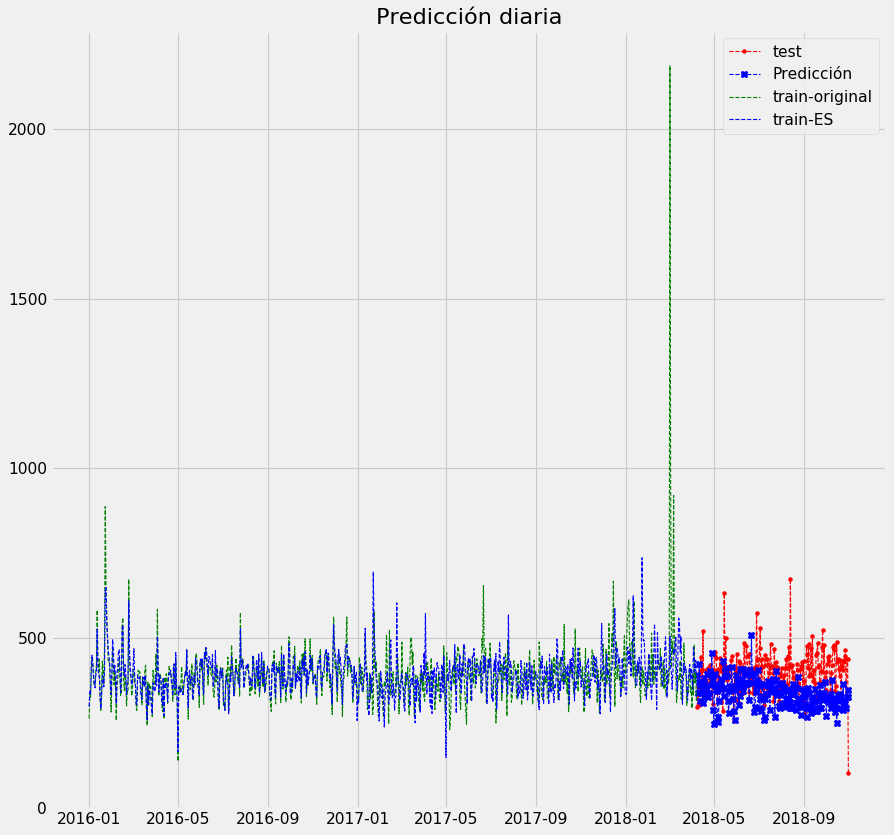

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_diaria.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_diaria.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción diaria')
plt.legend()
plt.show()

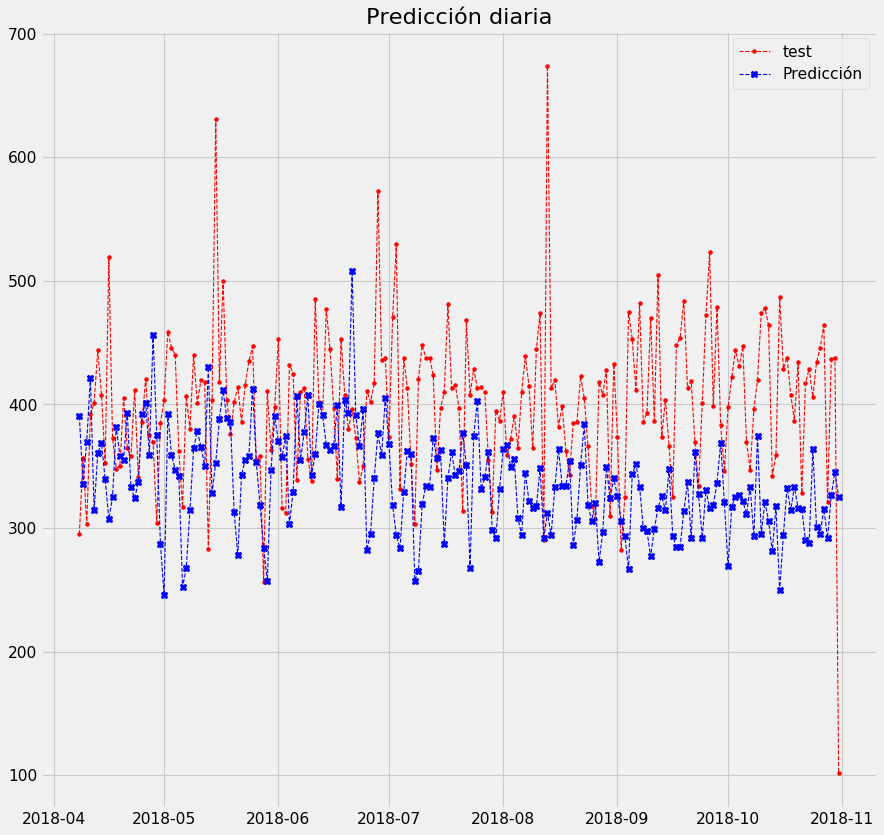

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción diaria')
plt.legend()
plt.show()

##### Tendencia aditiva y estacionalidad multiplicativa

In [0]:
triple = ExponentialSmoothing(train,
                          trend='add',   
                          seasonal='mul',
                          seasonal_periods=365,
                          ).\
fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
        
triple_preds = triple.forecast(len(test))

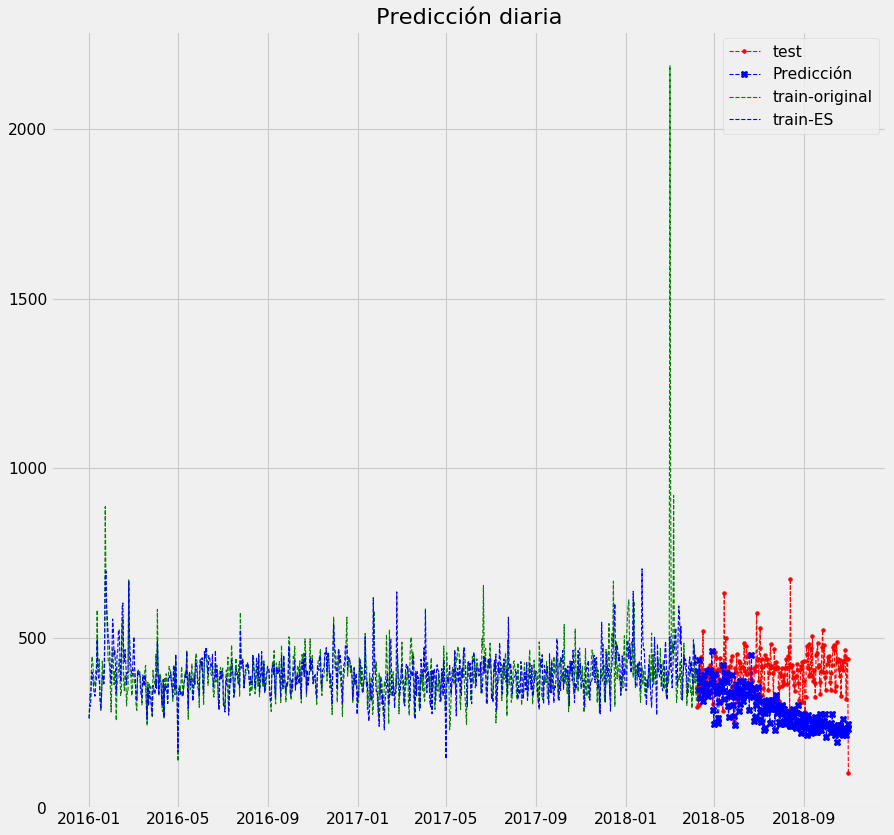

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_diaria.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_diaria.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción diaria')
plt.legend()
plt.show()

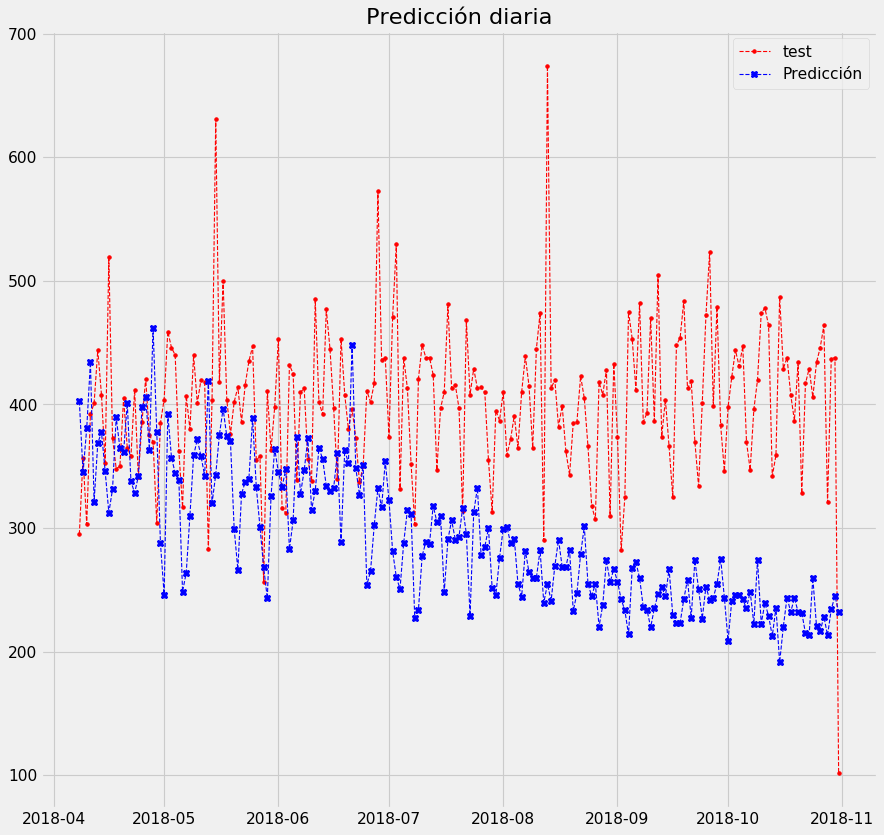

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción diaria')
plt.legend()
plt.show()

##### Tendencia multiplicativa y estacionalidad aditiva

In [0]:
triple = ExponentialSmoothing(train,
                          trend='mul',   
                          seasonal='add',
                          seasonal_periods=365,
                          ).\
fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
        
triple_preds = triple.forecast(len(test))

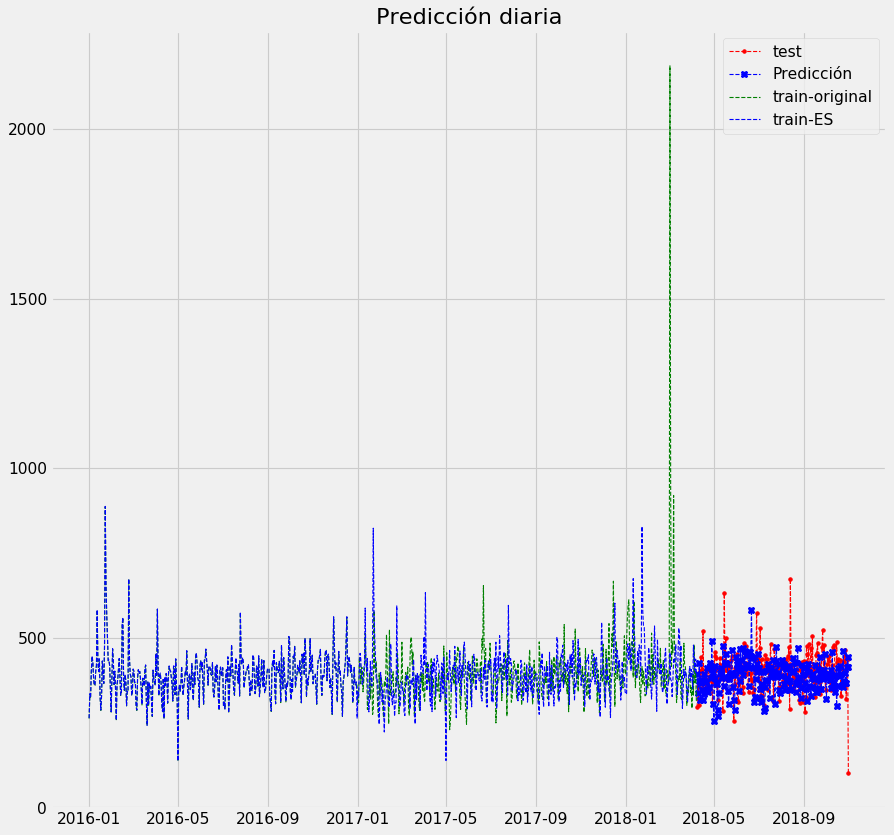

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_diaria.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_diaria.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción diaria')
plt.legend()
plt.show()


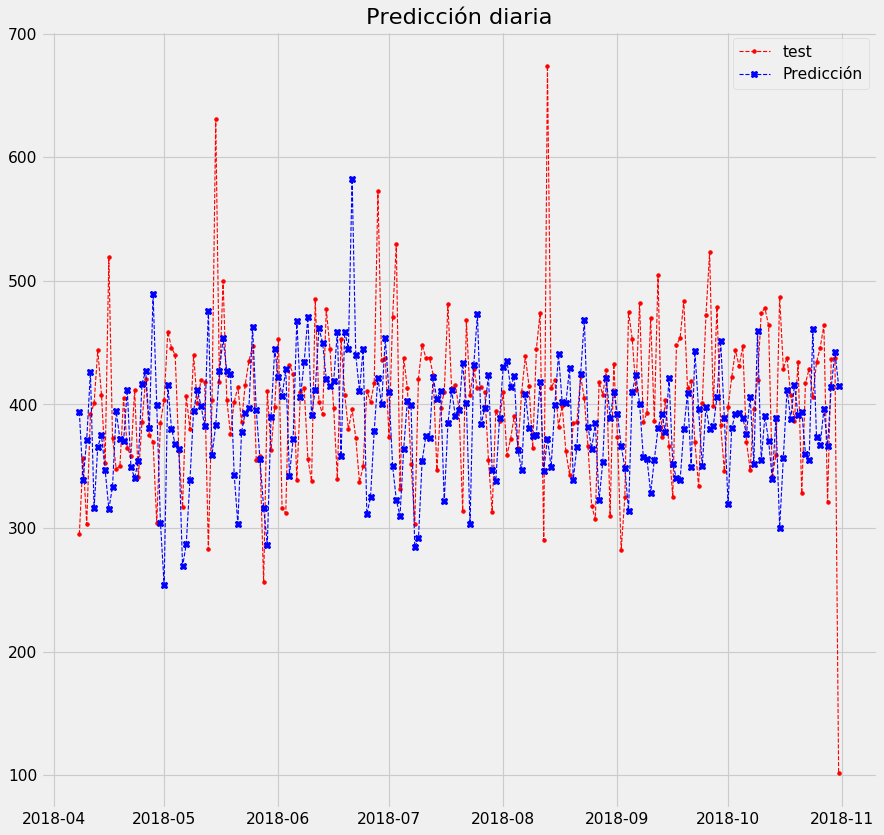

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción diaria')
plt.legend()
plt.show()


##### Tendencia multiplicativa y estacionalidad multiplicativa

In [0]:
triple = ExponentialSmoothing(train,
                          trend='mul',   
                          seasonal='mul',
                          seasonal_periods=365,
                          ).\
fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
        
triple_preds = triple.forecast(len(test))


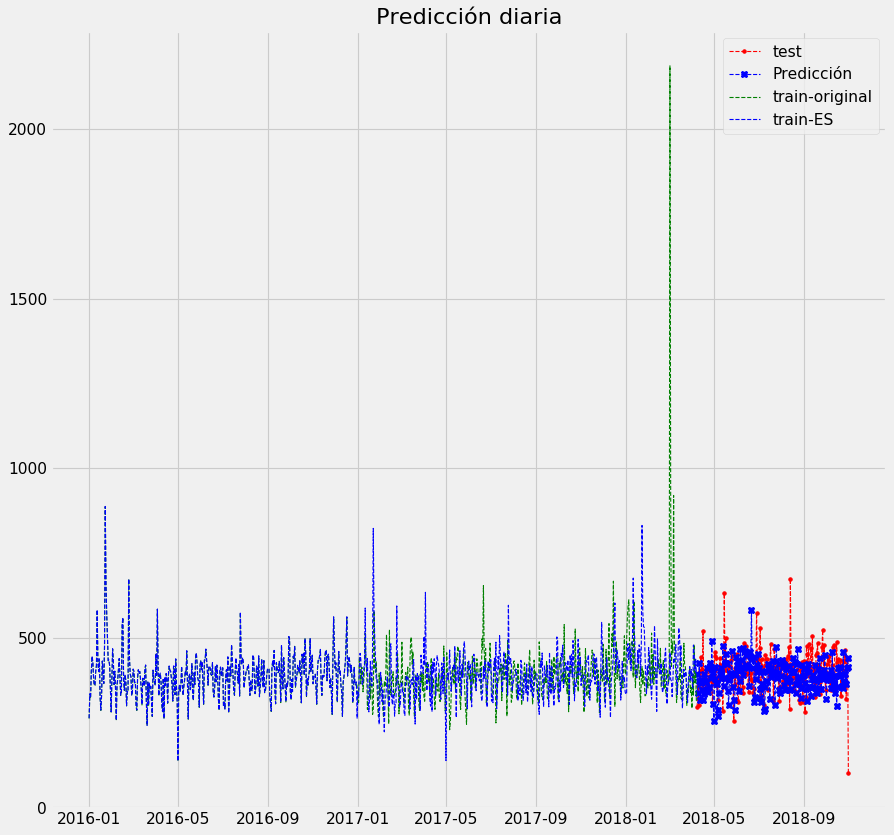

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_diaria.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_diaria.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción diaria')
plt.legend()
plt.show()

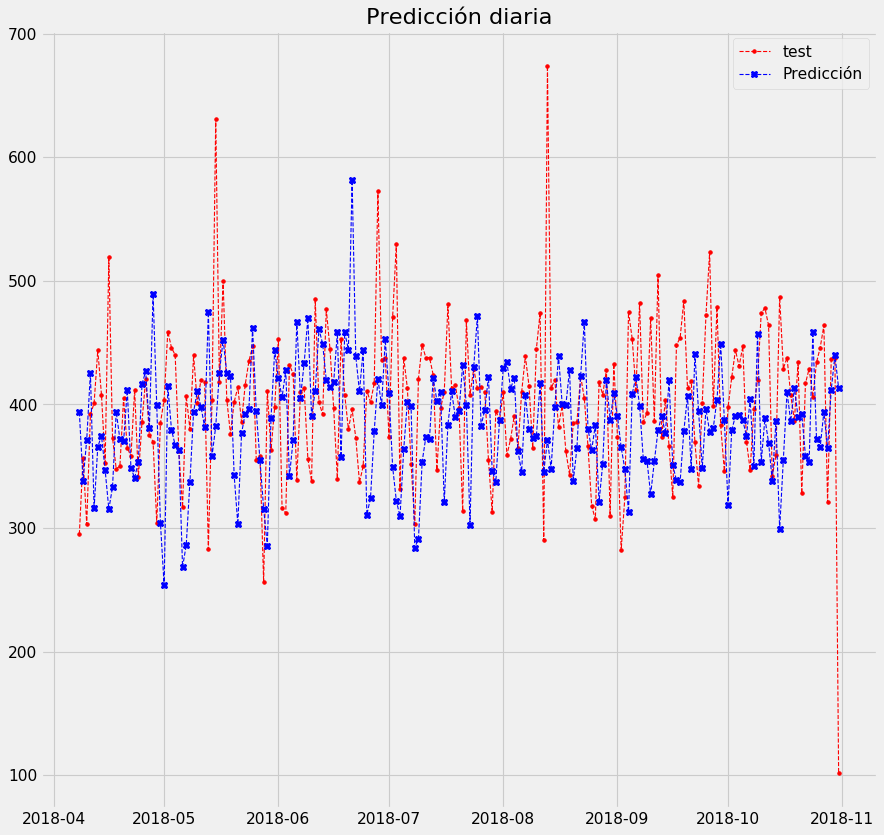

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_diaria.index[lim:], serie_diaria['Cantidad de llamadas'][lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_diaria.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción diaria')
plt.legend()
plt.show()

Si observamos los gráficos anteriores podemos ver que hay combinaciones de tendencia y estacionalidad que parecen adaptarse mejor a los datos que otros. 

Tenemos que elegir el modelo que más represente a nuestro problema.

#### Llamadas semanales


En este caso vamos a tener una menor densidad de puntos, por lo tanto, va a tener una menor cantidad de picos.

Veamos qué resultado da con la función para obtener la mejor estimación.

In [0]:
# vamos a separar en train y test
train, test, lim = sep_train_test(serie_semanal)
train = train.values
test = test.values

In [0]:
# busco la mejor combinacion de hiperparametros
conv, lim, n = enc_hiperparametros(pd.DataFrame(serie_semanal), porcentaje=0.8, periodo=53)

65


In [0]:
if (conv[n][0]==None):
    triple = ExponentialSmoothing(train,
                              trend=conv[n][0],    
                              seasonal=conv[n][1], 
                              seasonal_periods=53,
                              ).\
    fit(optimized=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
        
else:
    triple = ExponentialSmoothing(train,
                              trend=conv[n][0],    
                              seasonal=conv[n][1],  
                              seasonal_periods=53,
                              damped=conv[n][2]).\
    fit(optimized=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
    
triple_preds = triple.forecast(len(test))


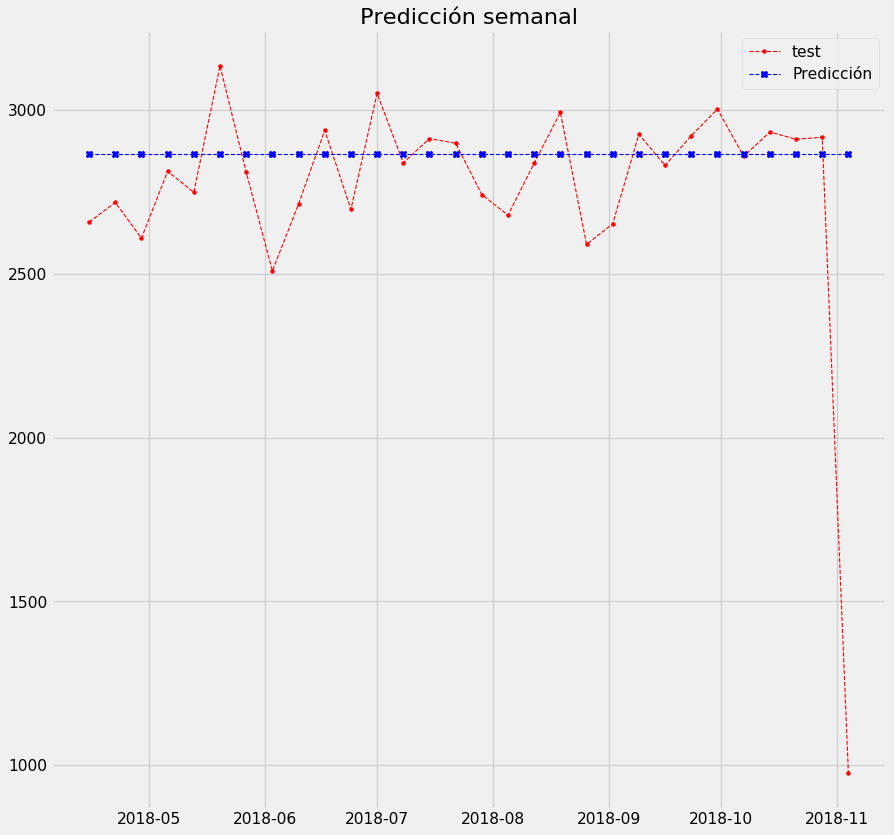

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción semanal')
plt.legend()
plt.show()


In [0]:
# con esto obtengo la mejor combinacion  de hiperparametros
print('Tendencia: ',conv[n][0])
print('Estacionalidad: ',conv[n][1])


Tendencia:  None
Estacionalidad:  None


In [0]:
triple.params


{'damping_slope': nan,
 'initial_level': 504.8059365650612,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': nan,
 'lamda': 0.7553492633496487,
 'remove_bias': False,
 'smoothing_level': 0.053578870087644344,
 'smoothing_seasonal': nan,
 'smoothing_slope': nan,
 'use_boxcox': True}

En el gráfico anterior se ve nuevamente el "suavizado" de los datos. También observamos que la función enc_hiperparametros encuentra que el mejor modelo para este caso no posee periodicidad. Los valores para 𝛼 (smoothing_level) y 𝛽 (smoothing_slope)son respectivamente 0.059 y 0.0, 𝛾 (smoothing_seasonal) aparece como nan debido a que es el parámetro de la parte períodica.

En este caso, podemos decir que el modelo que se usó es un exponencial smoothing doble.


A continuación exploraremos las siguientes combinaciones:

* Tendencia aditiva y estacionalidad aditiva
* Tendencia aditiva y estacionalidad multiplicativa
* Tendencia multiplicativa y estacionalidad aditiva
* Tendencia multiplicativa y estacionalidad multiplicativa

##### Tendencia aditiva y Estacionalidad aditiva

In [0]:
triple = ExponentialSmoothing(train,
                          trend='add',    
                          seasonal='add', 
                          seasonal_periods=53,
                          ).\
fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
        
triple_preds = triple.forecast(len(test))


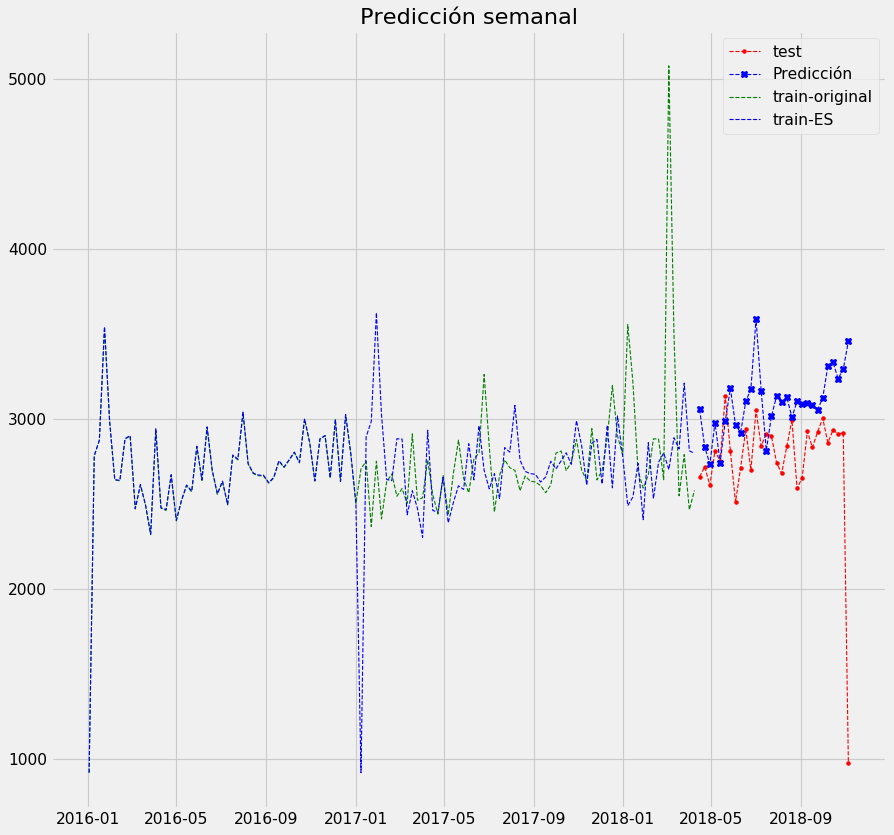

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_semanal.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_semanal.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción semanal')
plt.legend()
plt.show()


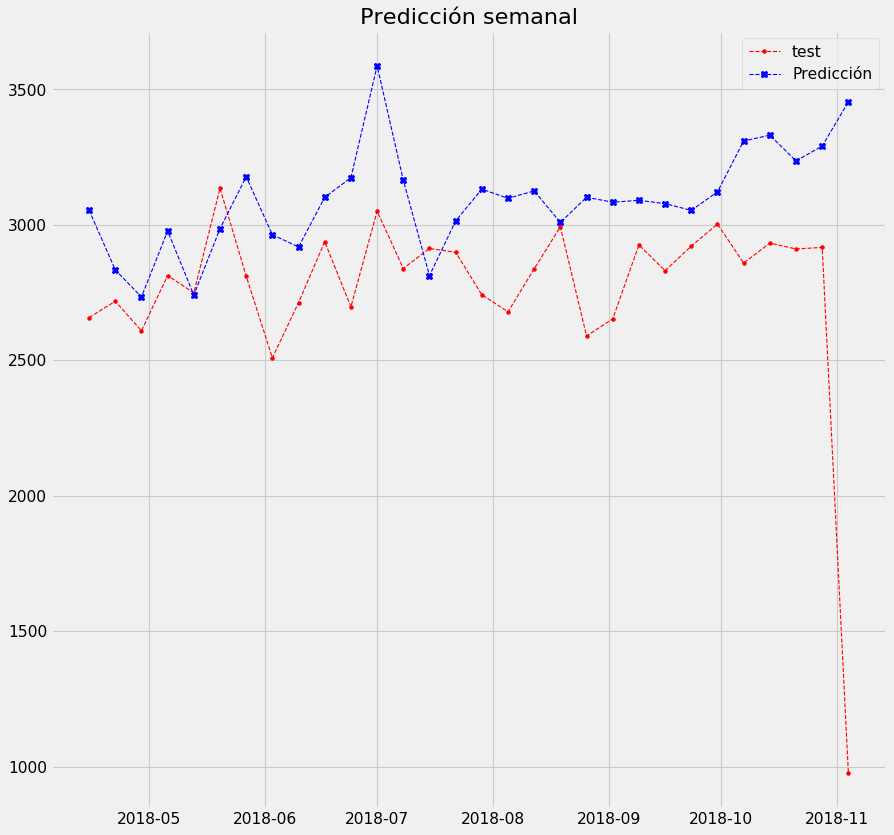

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción semanal')
plt.legend()
plt.show()


##### Tendencia aditivo y estacionalidad multiplicativa.


In [0]:
triple = ExponentialSmoothing(train,
                          trend='add',    
                          seasonal='mul', 
                          seasonal_periods=53,
                          ).\
fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])

triple_preds = triple.forecast(len(test))

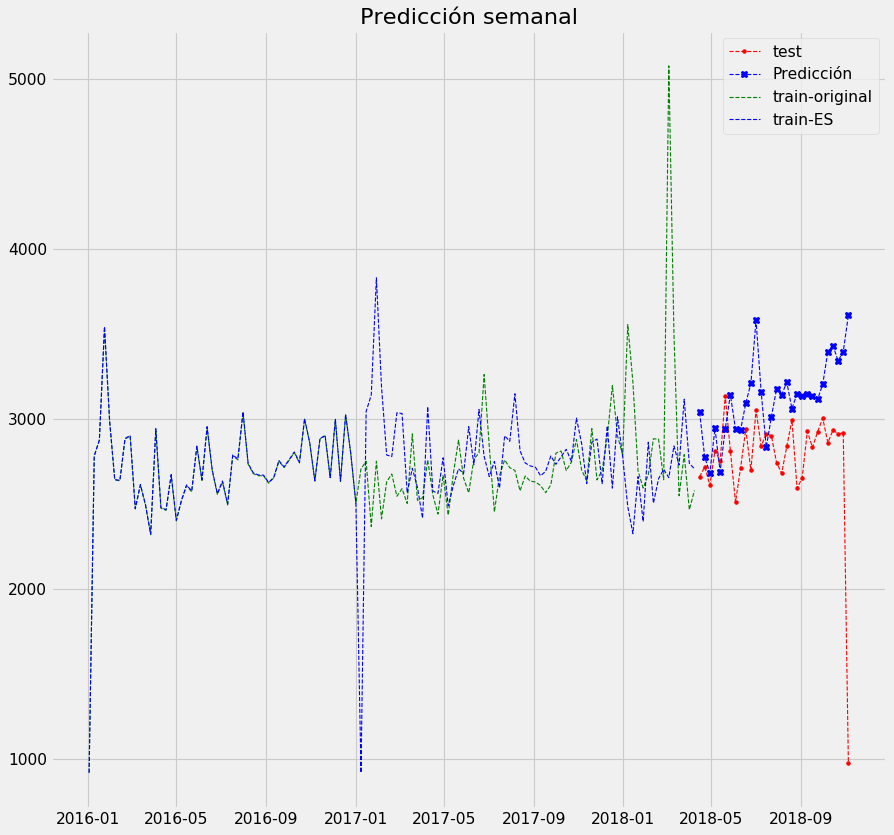

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_semanal.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_semanal.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción semanal')
plt.legend()
plt.show()


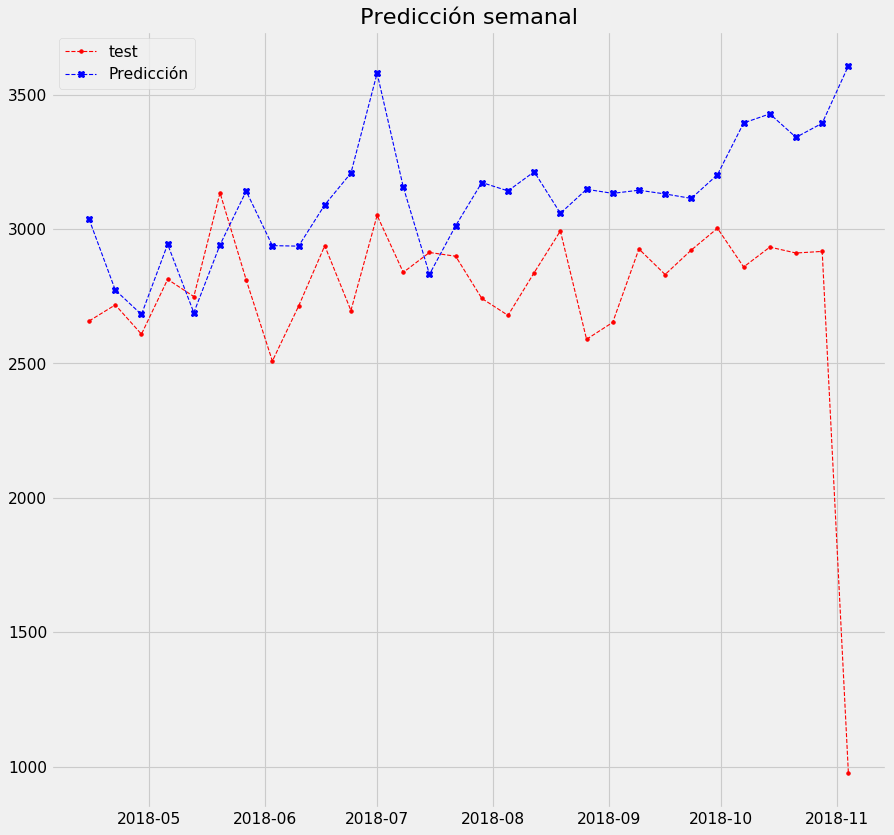

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción semanal')
plt.legend()
plt.show()


##### Tendencia multiplicativa y estacionalidad aditiva.

In [0]:
triple = ExponentialSmoothing(train,
                          trend='mul',    
                          seasonal='add', 
                          seasonal_periods=53,
                          ).\
fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
        
triple_preds = triple.forecast(len(test))


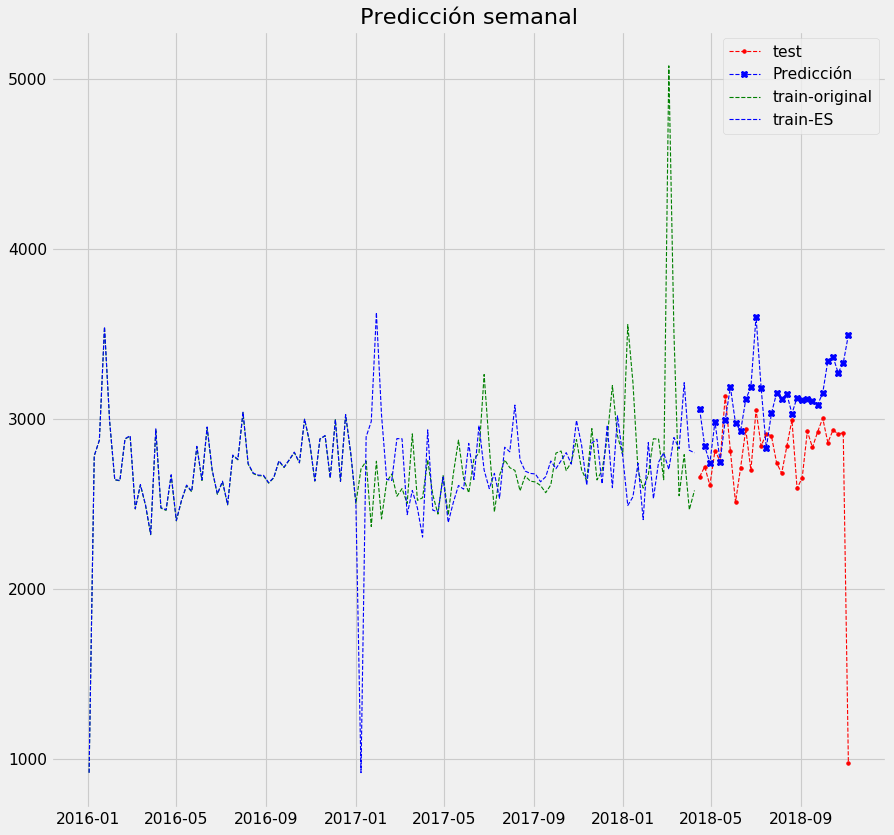

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_semanal.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_semanal.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción semanal')
plt.legend()
plt.show()


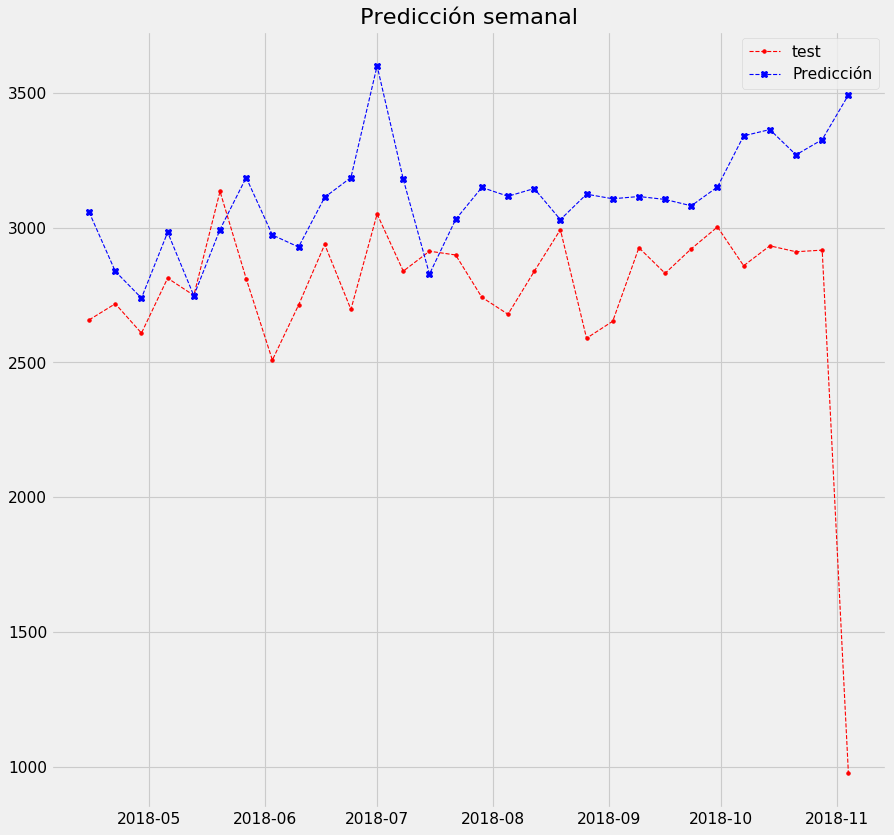

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción semanal')
plt.legend()
plt.show()

##### Tendencia multiplicativa y estacionalidad multiplicativa.

In [0]:
triple = ExponentialSmoothing(train,
                          trend='mul',    
                          seasonal='mul', 
                          seasonal_periods=53,
                          ).\
fit(use_brute=True, use_boxcox=conv[n][3], remove_bias=conv[n][4])
        
triple_preds = triple.forecast(len(test))

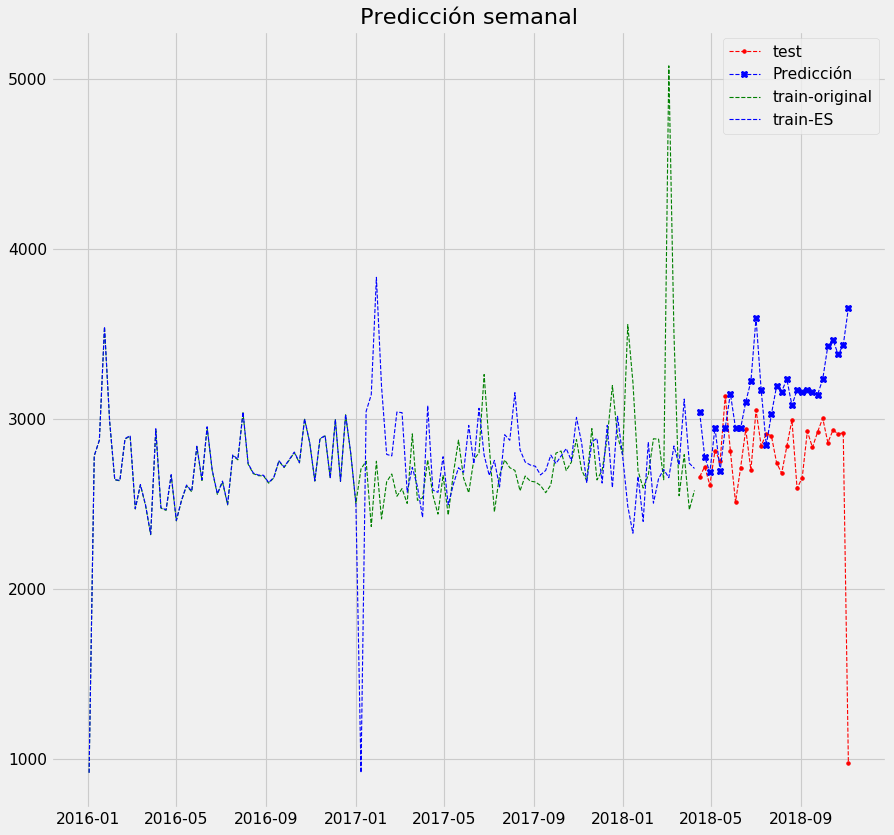

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.plot(serie_semanal.index[:lim], train, 
         ls='--',linewidth=1,color='green', label='train-original')

plt.plot(serie_semanal.index[:lim], triple.fittedvalues, 
         ls='--',linewidth=1,color='blue', label='train-ES')

plt.title('Predicción semanal')
plt.legend()
plt.show()


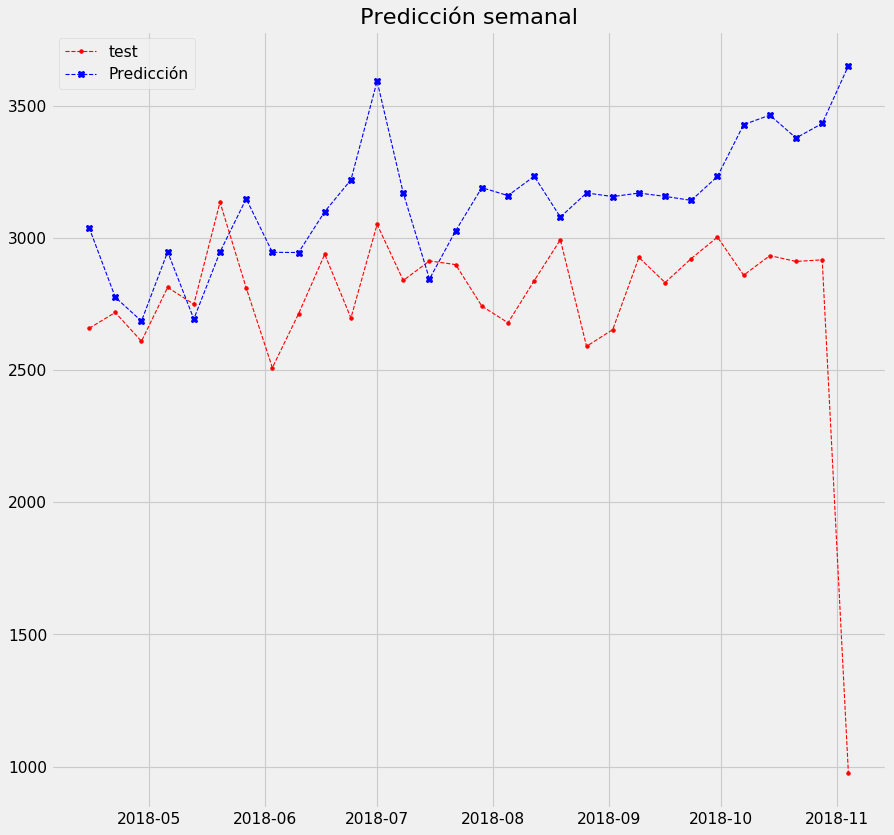

In [0]:
plt.figure(figsize=(12,12))
plt.plot(serie_semanal.index[lim:], serie_semanal[lim:], 
         marker='.', ls='--', linewidth=1,color='red', label='test')

plt.plot(serie_semanal.index[lim:], triple_preds, 
         marker='X', ls='--',linewidth=1,color='blue',label='Predicción')

plt.title('Predicción semanal')
plt.legend()
plt.show()


Si vemos los graficos podemos observar que el modelo que minimiza la metrica es un modelo de exponential smoothing doble pero si vemos los datos parecen tener una forma de un holtwinter con tendencia y estacionalidad aditiva pero viendo los graficos se ve que el modelo que mejor se adapta es holtwinter con tendencia multiplicativa y estacionalidad aditiva.

# XGBoost

### Funciones

In [0]:
def error(y_true, y_pred):
    print('Error absoluto medio: ',mean_absolute_error(y_true,y_pred))
    print('Error cuadrático medio: ',mean_squared_error(y_true,y_pred))
    print('R²: ',r2_score(y_true,y_pred))


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calcula el porcentaje del error absoluto medio dado y_true e y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


### Entrenamiento del modelo

En este caso vamor a usar TimeSeriesSplit de la libreria sklearn para que la separación de los datos en datos de entrenamiento y validadcion que hace GridSearchcv sea de manera que respete la cronología temporal de los datos.

In [0]:
parameters = {'max_depth':np.arange(3,11,1),
              'importance_type':['gain',
                                 'weight',
                                 'cover'],
             'n_estimators':np.arange(3000,5500,500)}
xgbr = XGBRegressor()
tscv = TimeSeriesSplit(n_splits=6) 
reg = GridSearchCV(xgbr,parameters,cv = tscv, scoring='neg_mean_squared_error', return_train_score=True )


Creamos columnas nuevas y entrenamos el modelo diario.

In [0]:
dfs =serie_diaria.copy()
dfs['timeStamp'] = dfs.index
dfs['dayofweek'] = dfs['timeStamp'].dt.dayofweek
dfs['quarter'] = dfs['timeStamp'].dt.quarter
dfs['month'] = dfs['timeStamp'].dt.month
dfs['year'] = dfs['timeStamp'].dt.year
dfs['dayofyear'] = dfs['timeStamp'].dt.dayofyear
dfs['dayofmonth'] = dfs['timeStamp'].dt.day
dfs['weekofyear'] = dfs['timeStamp'].dt.weekofyear

In [0]:
df_train = dfs[dfs['year']<2018]
df_test = dfs[dfs['year']>=2018]
x_train, y_train = df_train.drop(['timeStamp','Cantidad de llamadas'],axis=1),df_train['Cantidad de llamadas']
x_test, y_test = df_test.drop(['timeStamp','Cantidad de llamadas'],axis=1), df_test['Cantidad de llamadas']

reg.fit(x_train, y_train)


[12:02:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objectiv...
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'importance_type': ['gain', 'weight', 'cover'],
                         'm

### Predicción y comparación gráfica

In [0]:
df_test['pred'] = reg.predict(x_test)
df_all = pd.concat([df_test, df_train], sort=False)
df_all.tail()


Cantidad de llamadas  timeStamp  ...  weekofyear  pred
timeStamp                                    ...                  
2017-12-27                   387 2017-12-27  ...          52   NaN
2017-12-28                   352 2017-12-28  ...          52   NaN
2017-12-29                   447 2017-12-29  ...          52   NaN
2017-12-30                   506 2017-12-30  ...          52   NaN
2017-12-31                   392 2017-12-31  ...          52   NaN

[5 rows x 10 columns]

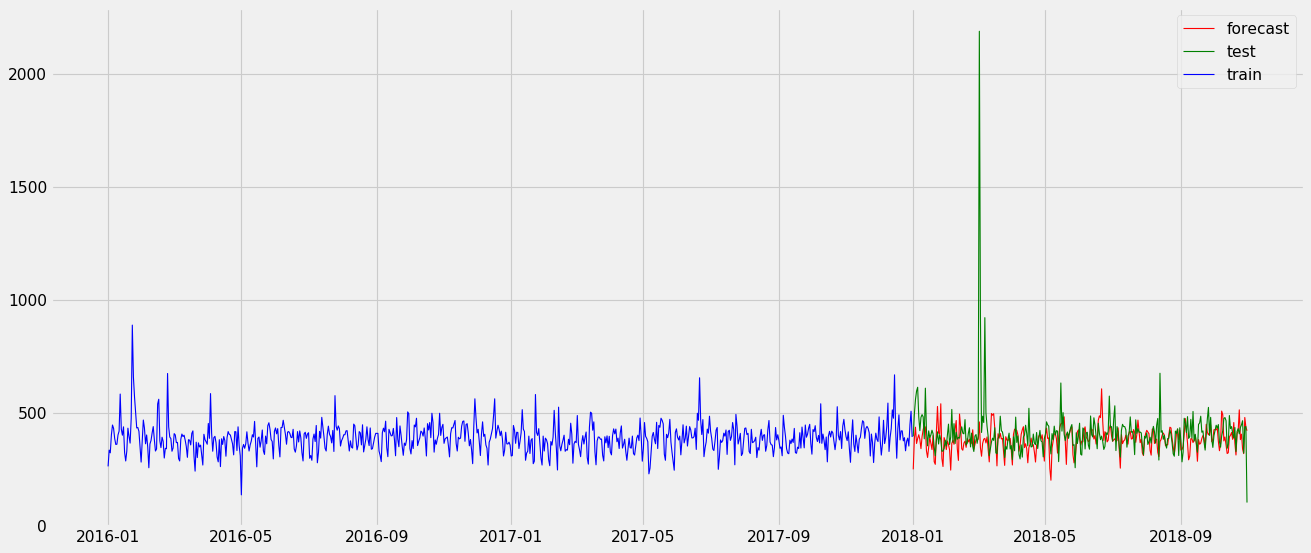

In [0]:
plt.figure(figsize=(18,8))
plt.plot(df_all[df_all['year']>=2018]['timeStamp'], 
         df_all[df_all['year']>=2018]['pred'], 
         'R',
         label='forecast',
         linewidth=1)

plt.plot(df_all[df_all['year']>=2018]['timeStamp'], 
         df_all[df_all['year']>=2018]['Cantidad de llamadas'],
         'G',
         label='test',
         linewidth=1)

plt.plot(df_all[df_all['year']<2018]['timeStamp'], 
         df_all[df_all['year']<2018]['Cantidad de llamadas'],
         'B',
         label='train',
         linewidth=1)

plt.legend()
plt.show()

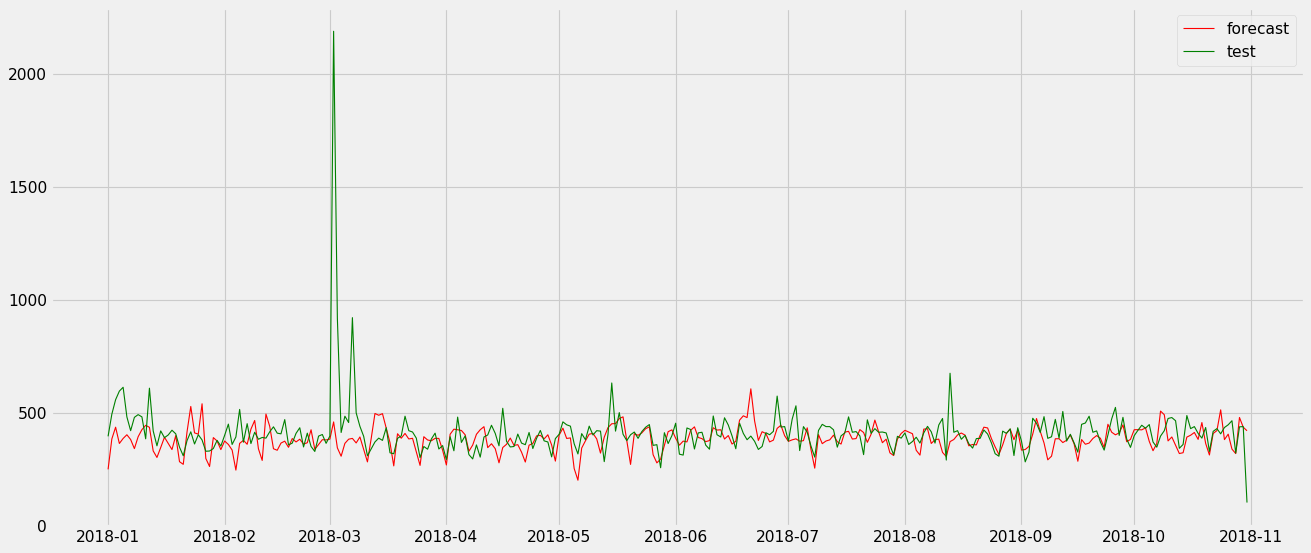

In [0]:
plt.figure(figsize=(18,8))
plt.plot(df_all[df_all['year']>=2018]['timeStamp'], 
         df_all[df_all['year']>=2018]['pred'], 
         'R',
         label='forecast',
         linewidth=1)

plt.plot(df_all[df_all['year']>=2018]['timeStamp'], 
         df_all[df_all['year']>=2018]['Cantidad de llamadas'],
         'G',
         label='test',
         linewidth=1)

plt.legend()
plt.show()


In [0]:
reg.best_params_

{'importance_type': 'gain', 'max_depth': 6, 'n_estimators': 3000}

In [0]:
error(df_test['Cantidad de llamadas'],df_test['pred'])

Error absoluto medio:  61.69960855182848
Error cuadrático medio:  16861.582799082797
R²:  -0.06109190321467639


Hacemos la prediccion por semana:

In [0]:
dfg_2 = serie_semanal.copy()

dfg_2 = pd.DataFrame(dfg_2)
dfg_2['timeStamp'] = dfg_2.index
dfg_2['weekofyear'] = dfg_2.timeStamp.dt.weekofyear
dfg_2['year'] = dfg_2.timeStamp.dt.year
dfg_2

Cantidad de llamadas  timeStamp  weekofyear  year
timeStamp                                                    
2016-01-03                   918 2016-01-03          53  2016
2016-01-10                  2781 2016-01-10           1  2016
2016-01-17                  2873 2016-01-17           2  2016
2016-01-24                  3539 2016-01-24           3  2016
2016-01-31                  2985 2016-01-31           4  2016
...                          ...        ...         ...   ...
2018-10-07                  2859 2018-10-07          40  2018
2018-10-14                  2933 2018-10-14          41  2018
2018-10-21                  2911 2018-10-21          42  2018
2018-10-28                  2917 2018-10-28          43  2018
2018-11-04                   977 2018-11-04          44  2018

[149 rows x 4 columns]

In [0]:
df_train = dfg_2[dfg_2['year']<2018]
df_test = dfg_2[dfg_2['year']>=2018]

x_train, y_train = df_train.drop(['Cantidad de llamadas','timeStamp'],axis=1),df_train['Cantidad de llamadas']
x_test, y_test = df_test.drop(['Cantidad de llamadas','timeStamp'],axis=1), df_test['Cantidad de llamadas']
reg.fit(x_train, y_train)

[12:13:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=6),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objectiv...
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'importance_type': ['gain', 'weight', 'cover'],
                         'm

In [0]:
dfg_2.shape

(149, 4)

In [0]:
df_test['pred'] = reg.predict(x_test)
df_all = pd.concat([df_train, df_test], sort=False)
df_all.head()

Cantidad de llamadas  timeStamp  weekofyear  year  pred
timeStamp                                                          
2016-01-03                   918 2016-01-03          53  2016   NaN
2016-01-10                  2781 2016-01-10           1  2016   NaN
2016-01-17                  2873 2016-01-17           2  2016   NaN
2016-01-24                  3539 2016-01-24           3  2016   NaN
2016-01-31                  2985 2016-01-31           4  2016   NaN

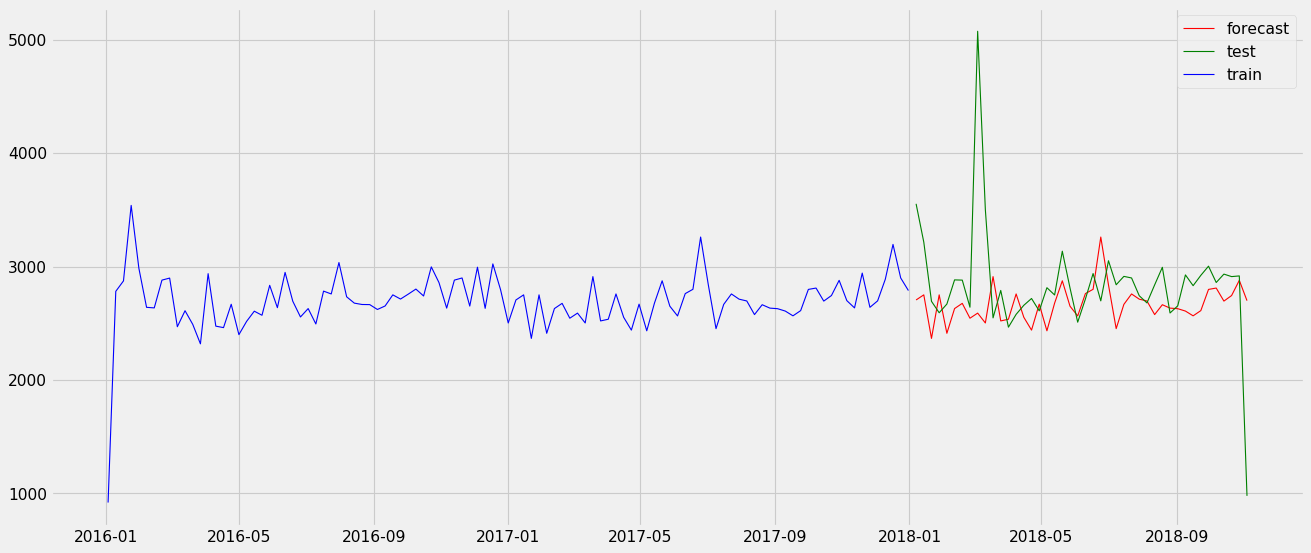

In [0]:
plt.figure(figsize=(18,8))
plt.plot(df_all[df_all['year']>=2018]['timeStamp'], 
         df_all[df_all['year']>=2018]['pred'], 
         'R',
         label='forecast',
         linewidth=1)

plt.plot(df_all[df_all['year']>=2018]['timeStamp'], 
         df_all[df_all['year']>=2018]['Cantidad de llamadas'],
         'G',
         label='test',
         linewidth=1)

plt.plot(df_all[df_all['year']<2018]['timeStamp'], 
         df_all[df_all['year']<2018]['Cantidad de llamadas'],
         'B',
         label='train',
         linewidth=1)

plt.legend()
plt.show()


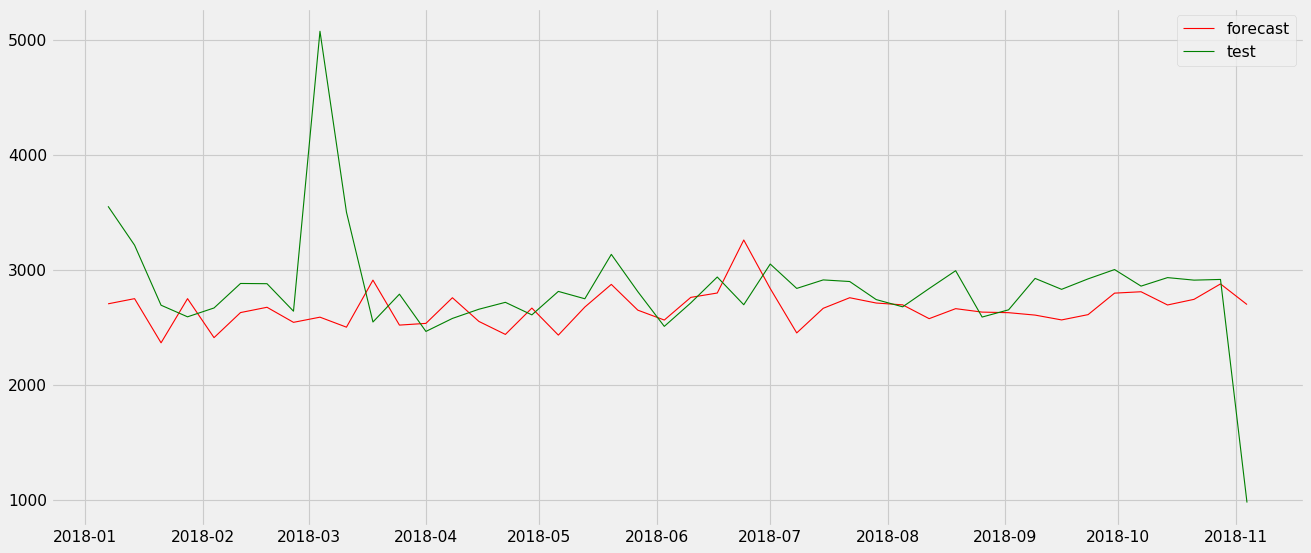

In [0]:
plt.figure(figsize=(18,8))
plt.plot(df_all[df_all['year']>=2018]['timeStamp'], 
         df_all[df_all['year']>=2018]['pred'], 
         'R',
         label='forecast',
         linewidth=1)

plt.plot(df_all[df_all['year']>=2018]['timeStamp'], 
         df_all[df_all['year']>=2018]['Cantidad de llamadas'],
         'G',
         label='test',
         linewidth=1)

plt.legend()
plt.show()


In [0]:
reg.best_params_

{'importance_type': 'gain', 'max_depth': 10, 'n_estimators': 3000}

Podemos ver que el inconveniente de XGBoost es que no acepta datos de formato fecha, por lo tanto, hay que hacer un tratamiento a estos datos para pasarlos a enteros (también acepta flotantes y booleanos), esto hace que se pierda un poco el significado de una serie pero también podemos observar en los gráficos que las predicciones se pueden considerar aceptables para el problema.

# Conclusión
En esta notebook mostramos como llevar a la práctica el análisis y la implementación de modelos para trabajar con series temporales (SARIMA, Holt-Winters y XGBoost). Por tal motivo el foco estuvo concentrado en dejar ejemplos de diferentes casos de entrenamiento con los algoritmos mencionados y no tanto en la calidad de las predicciones.

Esperamos que esta notebook sirva de guía y puntapié inicial para quien se este introduciendo en este tema y proporcione código reutilizable a ser replicado en diferentes series temporales. 
